In [2]:
import dask as da
import dask.dataframe as daskdf
import dask.array as daa
import dask.distributed as dd
import dask.datasets as ds
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import numpy as np
import graphviz
import joblib
import sys
import glob
import time

import os
os.environ["PATH"] += os.pathsep + 'D:\\Logiciels\\Graphviz\\bin'  # replace with your Graphviz bin path



# phase 1 : business understanding:
The National Railway Company of Belgium SNCB is responsible for
organizing and operating the rail service in Belgium. Within SNCB, the
Technics directorate is tasked with acquiring, updating, and maintaining the
rolling stock. Their objective is to deliver a superior service by ensuring the
availability of an ample supply of safe, dependable, and comfortable rolling
stock tailored to meet both operational and commercial requirements of
customers
1
. This project is sponsored by the rolling stock team, who
provide the data and the technical challenge.
The context of this challenge is the cooling of diesel trains
2
. SNCB’s diesel
trains are AR41 (Belgian Railways Class 41 - Wikipedia) and consist of 2
vehicles which are always coupled. Each of these vehicles is referenced in
the data: some_variable_name_PC1 and some_variable_name_PC2. Each
PC is equipped with 2 cooling systems: one for the engine air intake and
one for the oil of the transmission. In the latter, the water is the coolant
(water-oil intercooler) while in the former air is used as coolant (air-air
intercooler).
Maintaining these systems working properly is important for the health of
the diesel engines and transmission and to avoid incidents. In operations, if
one of the engines fails, then the other can serve as a backup. However, if
the backup fails then there will be a train delay. It is of everybody’s interest
to keep both engines working properly and making sure the temperatures
and pressures stay within acceptable ranges.
2 5% of SNCB trains are diesel-powered, 95% electric.
1 https://www.belgiantrain.be/en/about-sncb/enterprise/management-structure/directions/technics
The maximum acceptable temperatures are for the: air: 65°C, water:
100°C, oil: 115°C. Above those thresholds the engines are stopped
automatically to avoid damage.
Just like in life, problems arise. Here the anomalies could come from: a
sensor, a cooling system, an engine, both engines, or external sources:
weather is too hot, pollen gets stuck into the radiators, etc. Being able to
capture and to distinguish some of these potential failures and to predict
them in advance will help preserve vehicles’ health and prevent train
incidents.


# phase 2 : data understanding 
This phase involves initial data collection, increasing familiarity with data, identifying quality problems, and forming hypotheses. Steps include collecting initial data, describing data, exploring data, and verifying data quality.

Collect the Initial Data:

Acquire necessary data, report encountered problems and solutions.
Describe the Data:

Examine data format, quantity, structure, and other surface features.
Ensure data meets relevant requirements.
Explore the Data:

Use querying, visualization, and reporting to answer data mining questions.
Create a data exploration report with initial findings.
Verify Data Quality:

Examine data completeness, missing values, attribute meanings, and anomalies.
Address quality problems reported in the earlier step.



In [3]:

"""data look like this: ;mapped_veh_id;timestamps_UTC;lat;lon;RS_E_InAirTemp_PC1;RS_E_InAirTemp_PC2;RS_E_OilPress_PC1;RS_E_OilPress_PC2;RS_E_RPM_PC1;RS_E_RPM_PC2;RS_E_WatTemp_PC1;RS_E_WatTemp_PC2;RS_T_OilTemp_PC1;RS_T_OilTemp_PC2
0;181;2023-08-01 03:44:12;50.7698183;3.8721144;27.0;23.0;255.0;238.0;794.0;801.0;83.0;81.0;76.0;77.0
1;143;2023-08-01 06:36:29;51.0399934;3.6934285;33.0;32.0;272.0;324.0;802.0;804.0;78.0;78.0;73.0;74.0
2;183;2023-08-24 06:53:54;50.7422026;3.6020347;31.0;33.0;234.0;182.0;799.0;802.0;82.0;82.0;85.0;87.0"""
# Load data
def load_data():
    print("Loading data...")
    start = time.time()
    df = daskdf.read_csv("ar41_for_ulb.csv", sep=';')
    end = time.time()
    print("Data loaded in {} seconds".format(end-start))
    return df

ddf = load_data()
ddf = ddf.drop(columns=['Unnamed: 0'])
# convert all temperatures from celcius to kelvin
ddf['RS_E_InAirTemp_PC1'] = ddf['RS_E_InAirTemp_PC1'] + 273.15
ddf['RS_E_InAirTemp_PC2'] = ddf['RS_E_InAirTemp_PC2'] + 273.15
ddf['RS_E_WatTemp_PC1'] = ddf['RS_E_WatTemp_PC1'] + 273.15
ddf['RS_E_WatTemp_PC2'] = ddf['RS_E_WatTemp_PC2'] + 273.15
ddf['RS_T_OilTemp_PC1'] = ddf['RS_T_OilTemp_PC1'] + 273.15
ddf['RS_T_OilTemp_PC2'] = ddf['RS_T_OilTemp_PC2'] + 273.15


Loading data...
Data loaded in 0.0355372428894043 seconds


In [4]:
# lets take 20% of data 
def take_sample(df, frac):
    print("Taking sample...")
    start = time.time()
    df = df.sample(frac=frac)
    end = time.time()
    print("Sample taken in {} seconds".format(end-start))
    return df

ddf = take_sample(ddf, 0.0001)

Taking sample...
Sample taken in 0.004314422607421875 seconds


In [5]:
# data description
def data_description(df):
    print("Data description:")
    print(df.head())
    print(df.shape)
    print("dataframe description")
    print(df.describe())

data_description(ddf)

Data description:
        mapped_veh_id       timestamps_UTC        lat       lon  \
220737          126.0  2023-03-12 01:00:10  50.855345  3.606268   
139807          152.0  2023-06-05 08:51:26  50.400155  4.460632   
359225          135.0  2023-07-29 09:15:04  51.002771  3.797032   
51863           108.0  2023-08-04 09:48:30  50.421241  4.537006   
558718          104.0  2023-03-07 10:48:18  50.342531  4.288307   

        RS_E_InAirTemp_PC1  RS_E_InAirTemp_PC2  RS_E_OilPress_PC1  \
220737                13.0                17.0              241.0   
139807                34.0                33.0              189.0   
359225                35.0                40.0              179.0   
51863                 46.0                48.0                3.0   
558718                30.0                36.0              220.0   

        RS_E_OilPress_PC2  RS_E_RPM_PC1  RS_E_RPM_PC2  RS_E_WatTemp_PC1  \
220737              224.0         797.0         802.0              80.0   
139807        

Exploring mapped_veh_id...
count    1771.000000
mean      150.744212
std        27.290622
min       102.000000
25%       137.000000
50%       162.000000
75%       186.000000
max       197.000000
Name: mapped_veh_id, dtype: float64


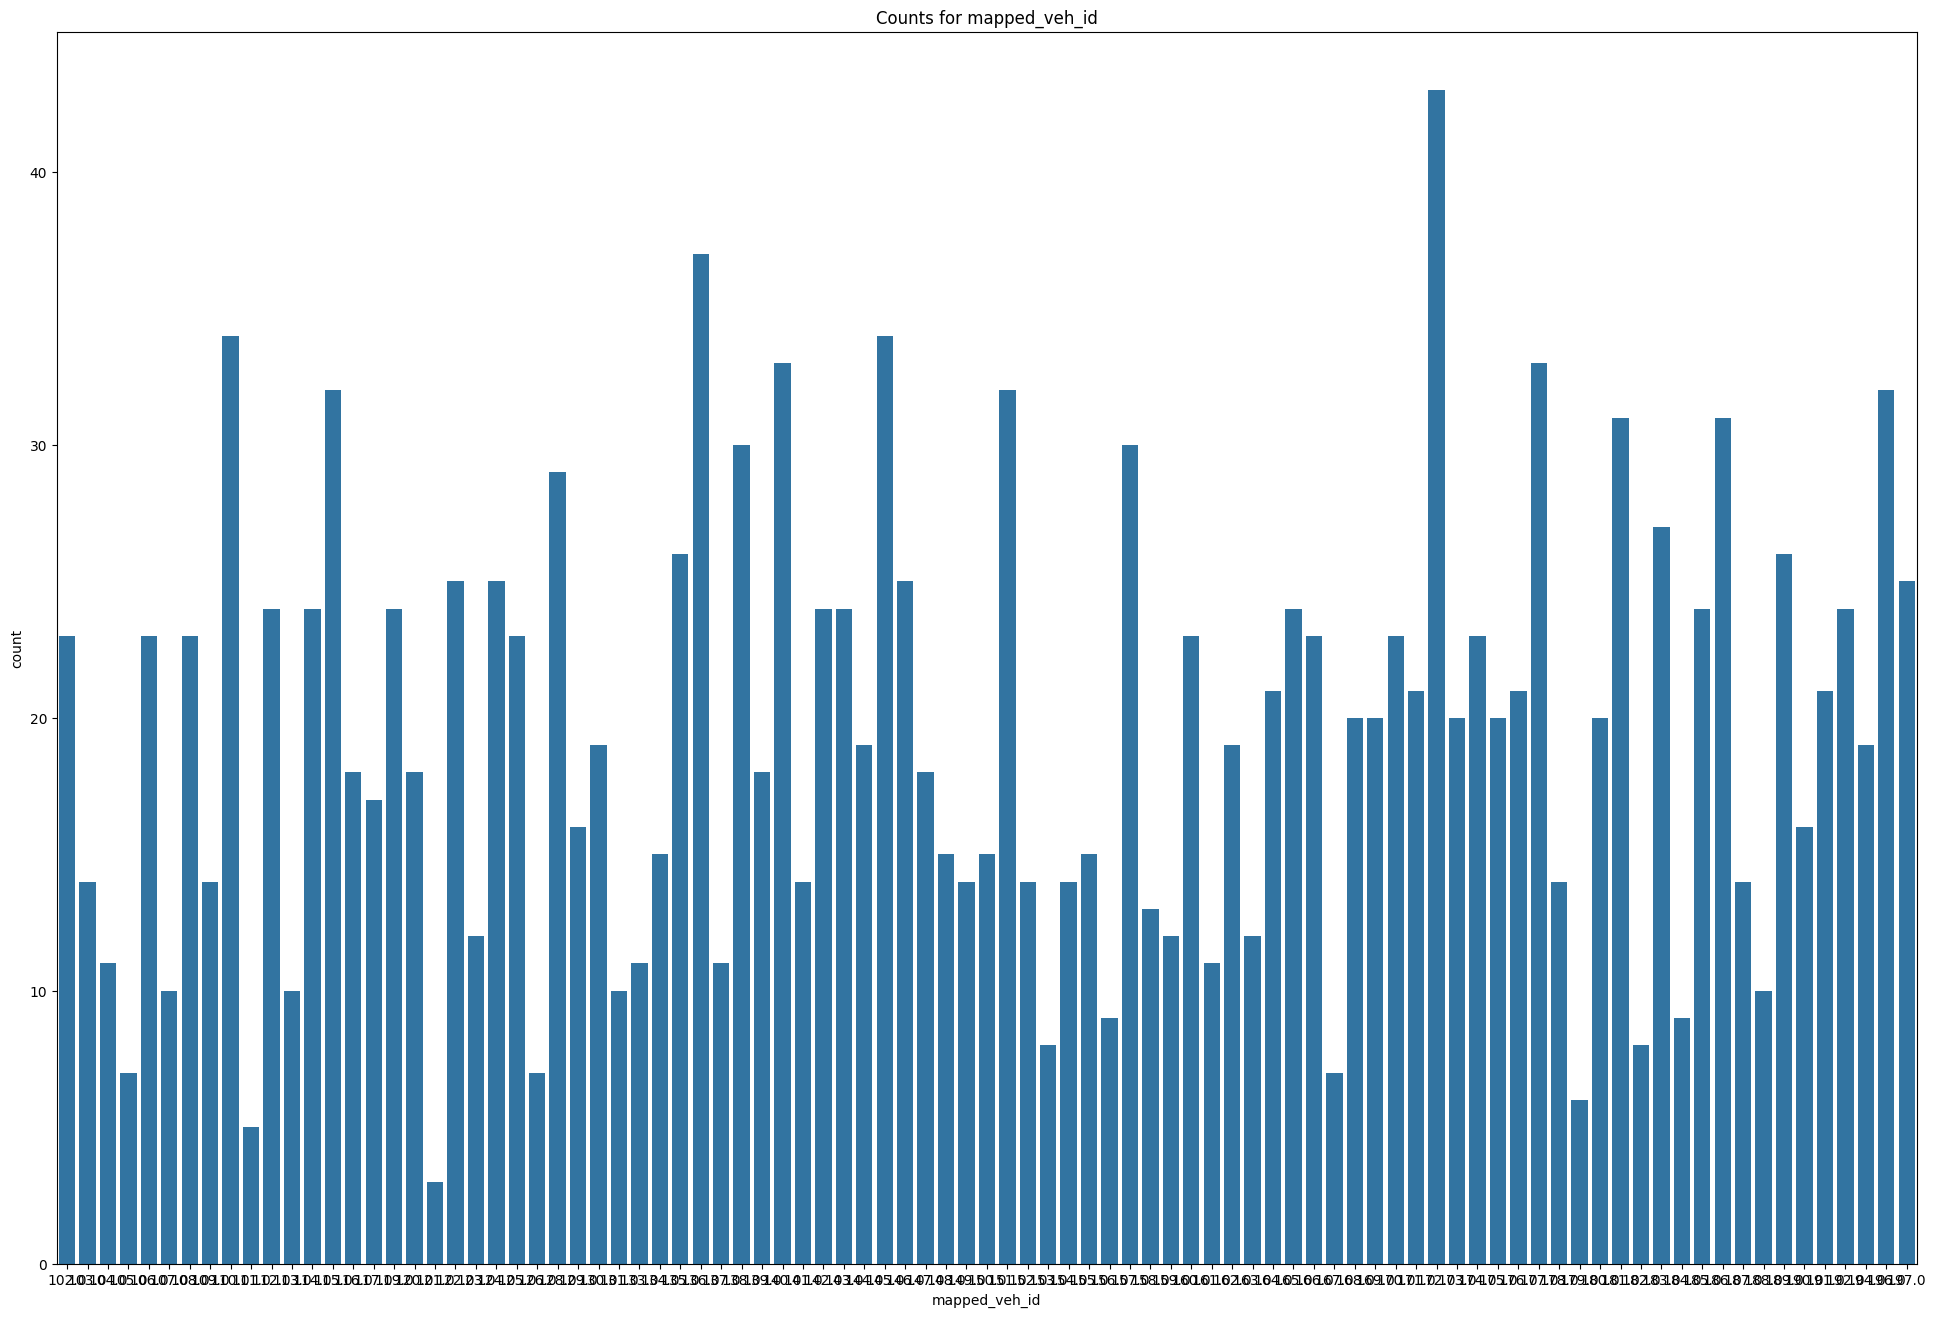

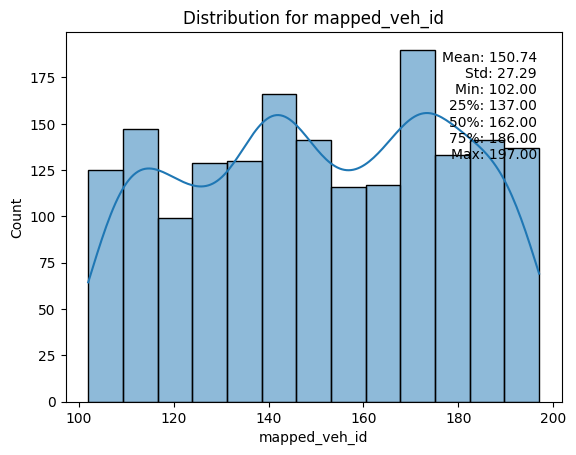

Exploring RS_E_InAirTemp_PC1...
count    1771.000000
mean       30.642951
std        11.855642
min         0.000000
25%        27.750000
50%        37.000000
75%        42.000000
max        80.000000
Name: RS_E_InAirTemp_PC1, dtype: float64


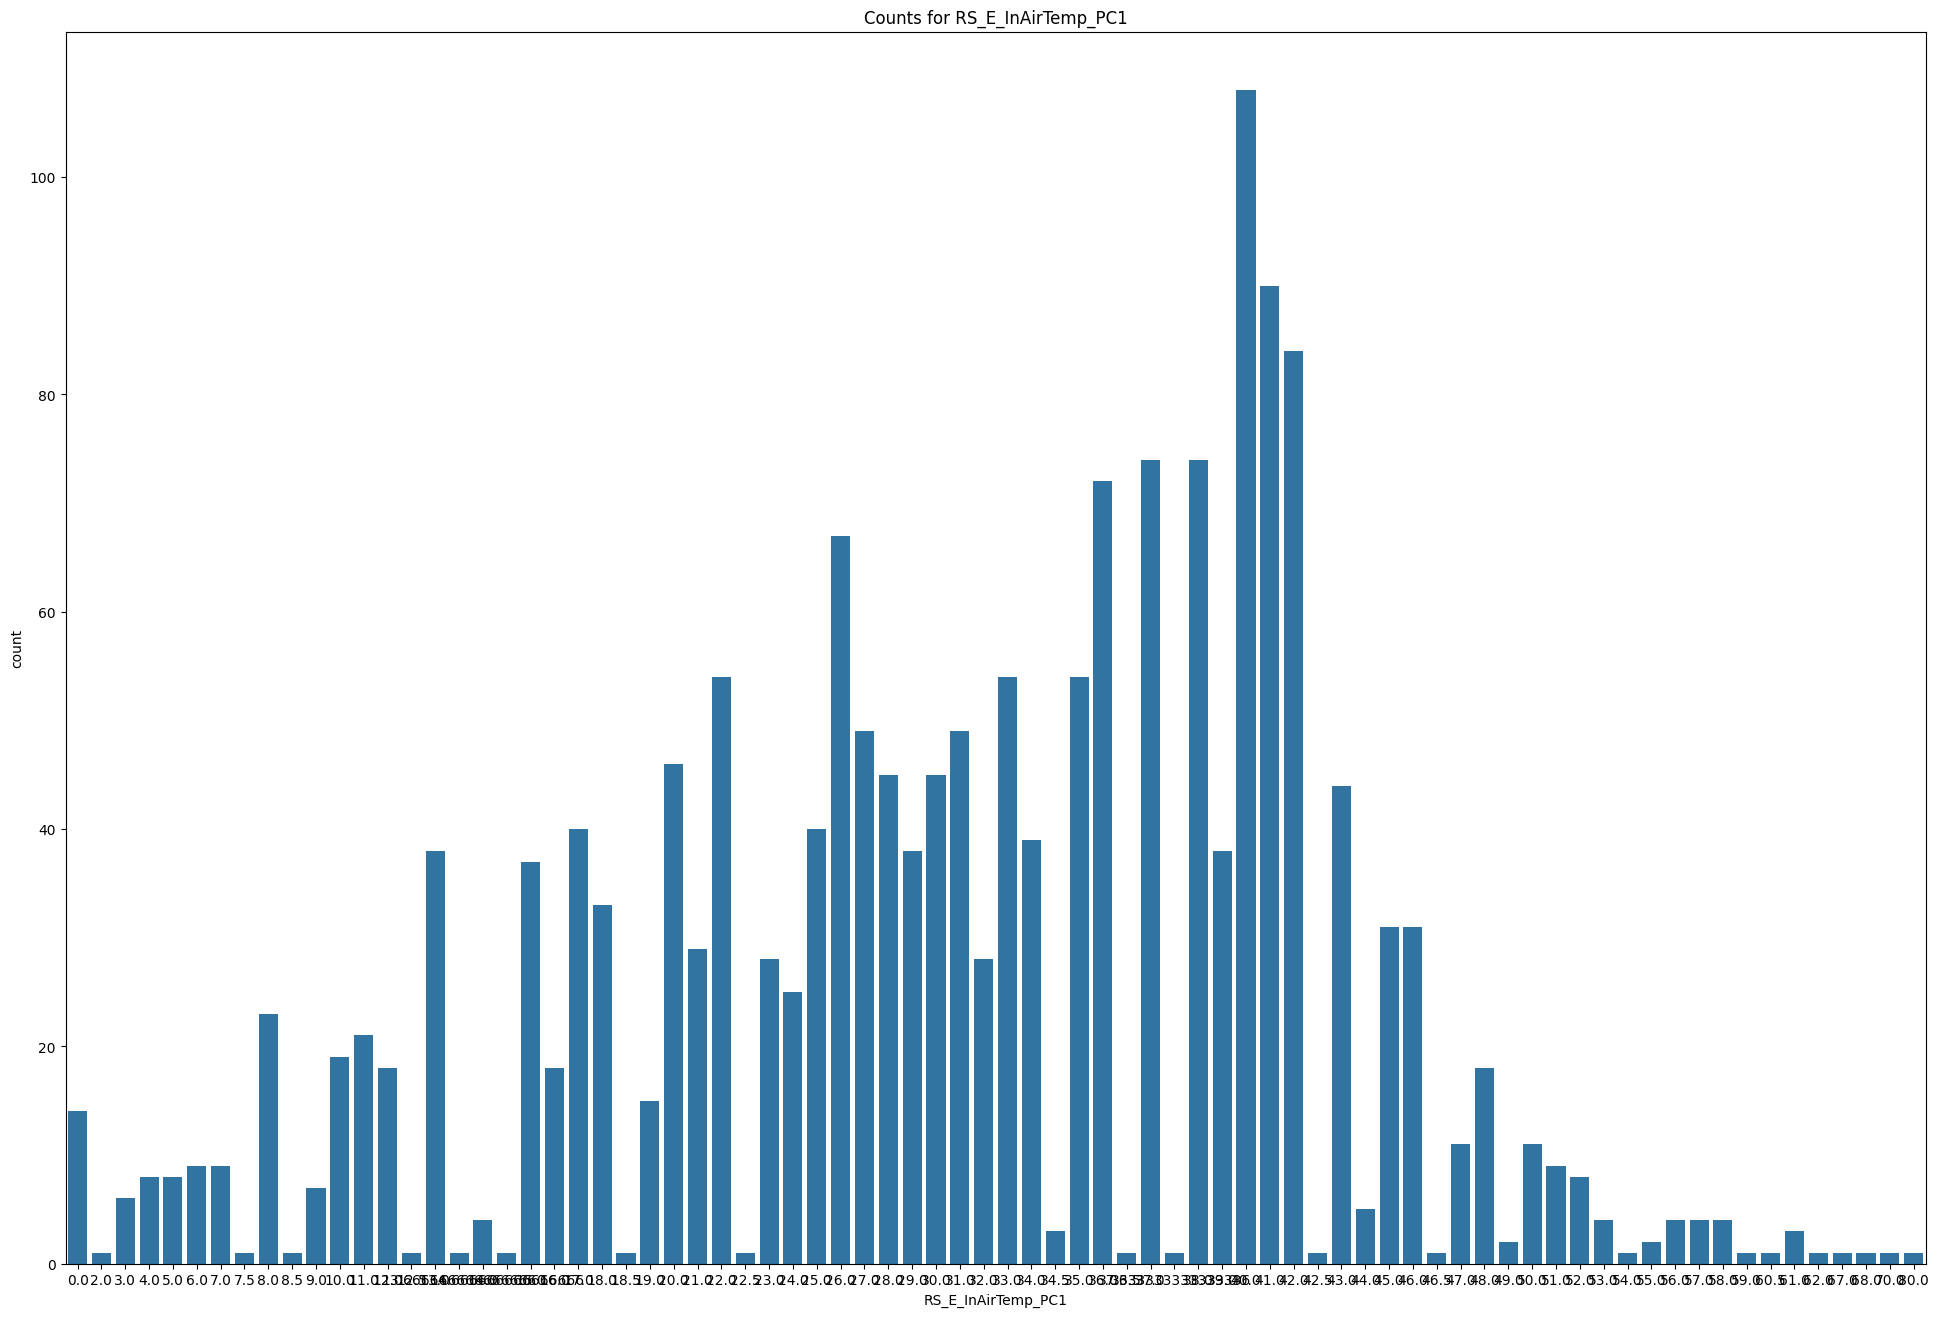

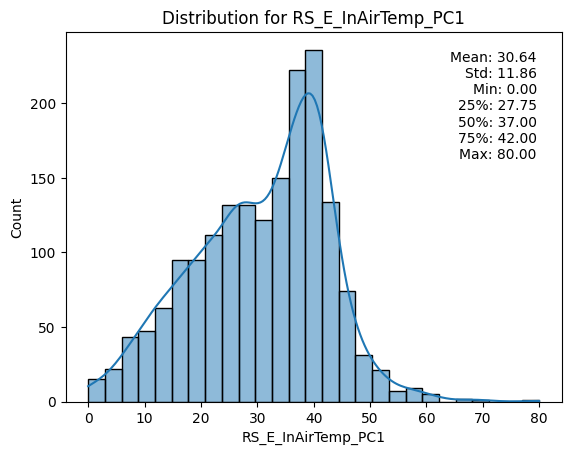

Exploring RS_E_InAirTemp_PC2...
count    1770.000000
mean       30.373861
std        11.538319
min         0.000000
25%        29.000000
50%        36.000000
75%        41.000000
max        68.000000
Name: RS_E_InAirTemp_PC2, dtype: float64


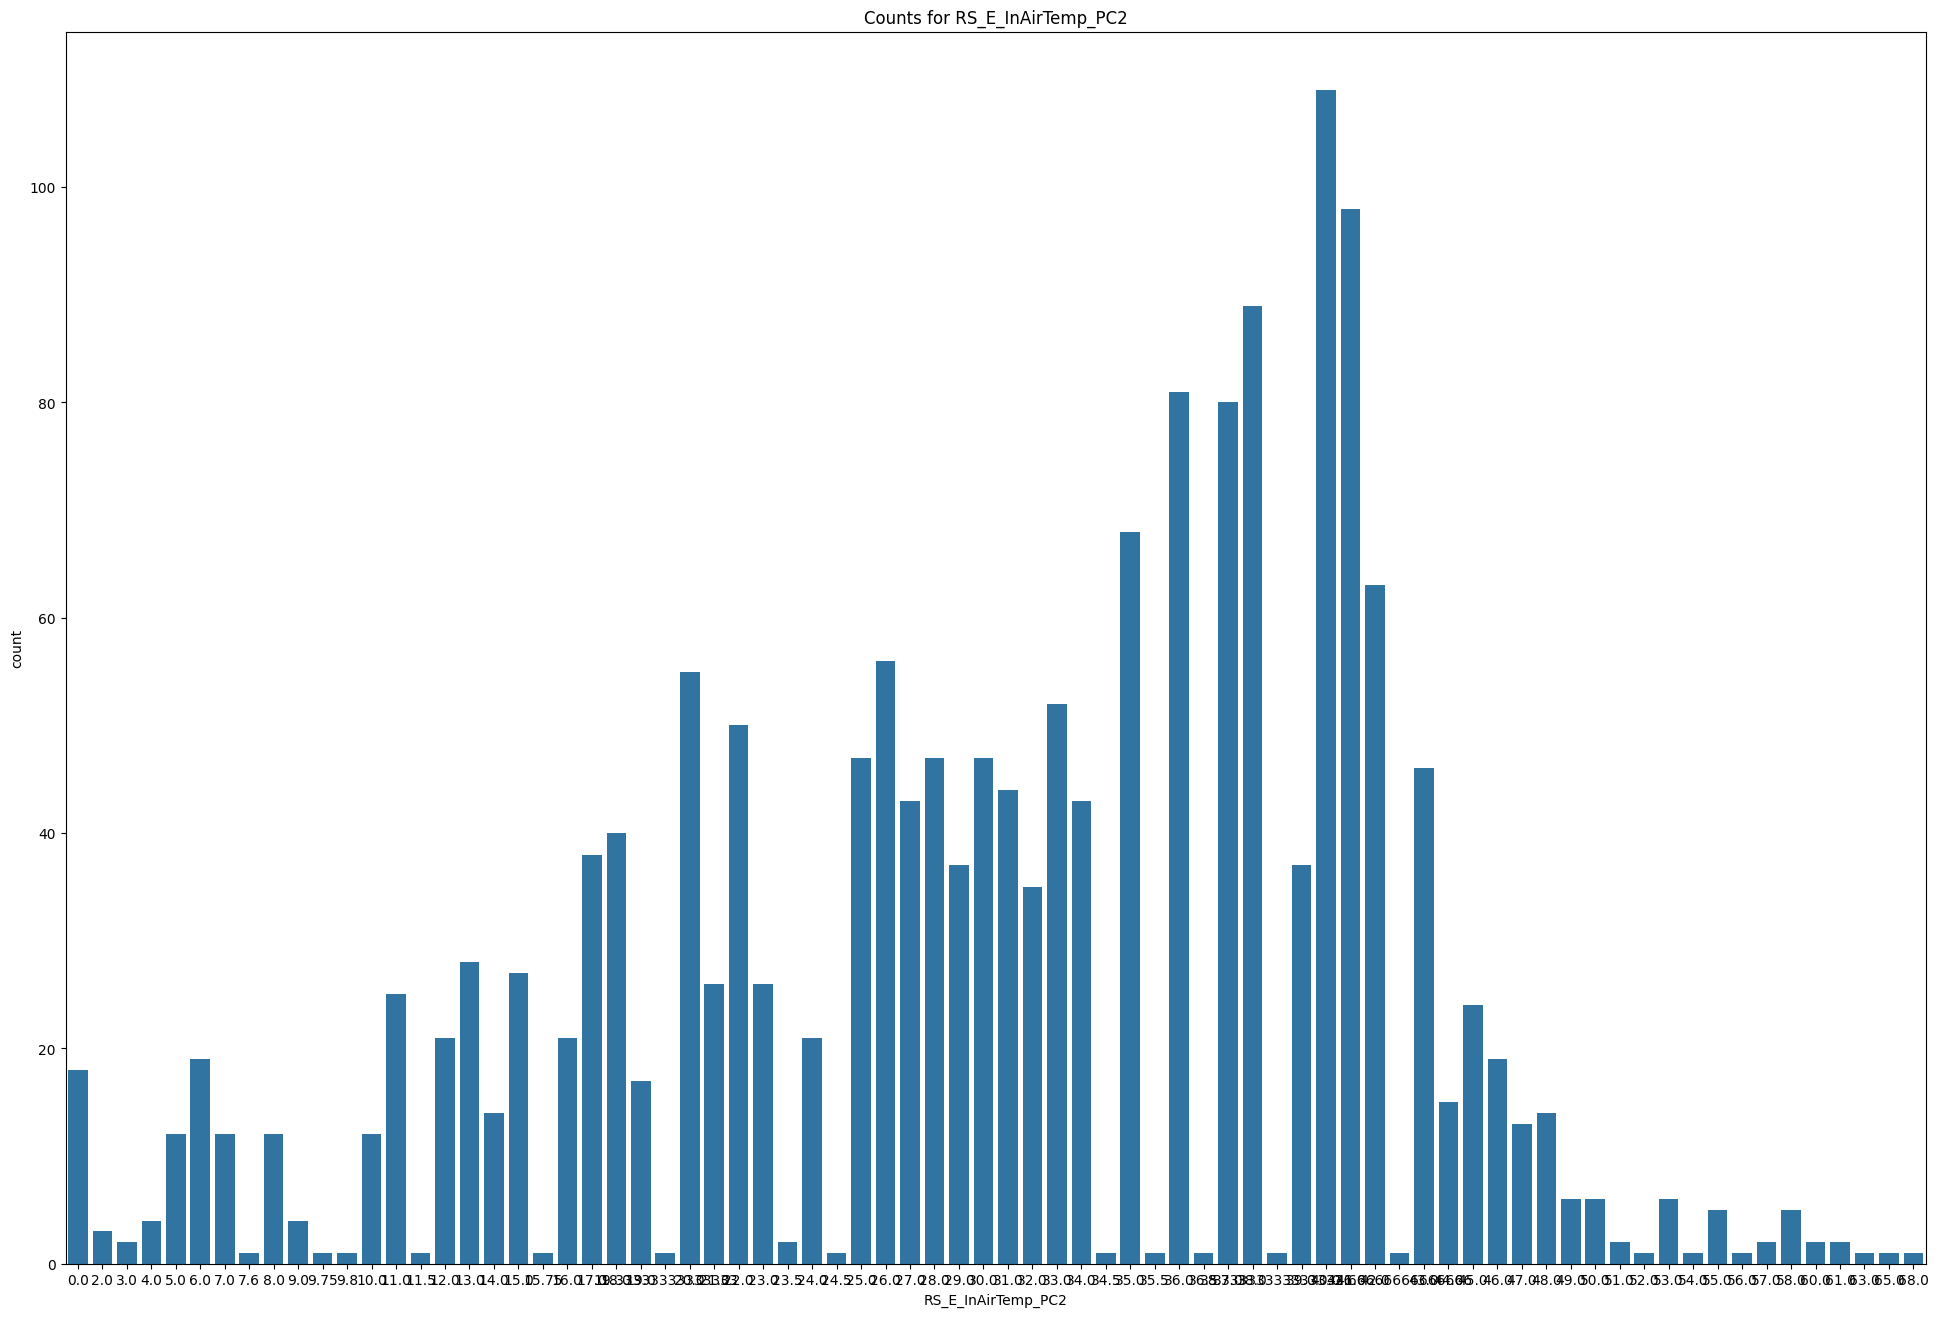

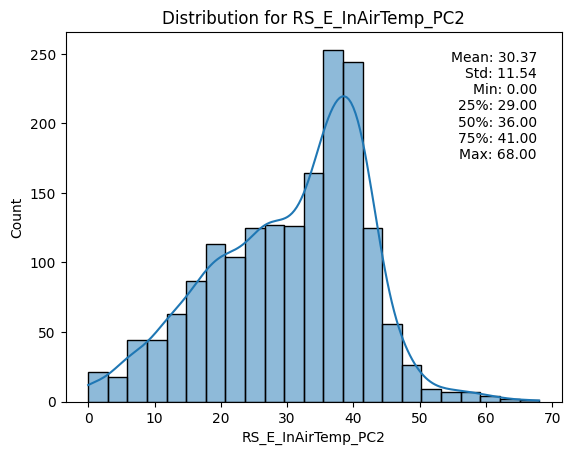

Exploring RS_E_OilPress_PC1...
count    1771.000000
mean      261.064390
std       118.797509
min         0.000000
25%       215.000000
50%       258.000000
75%       363.500000
max       690.000000
Name: RS_E_OilPress_PC1, dtype: float64


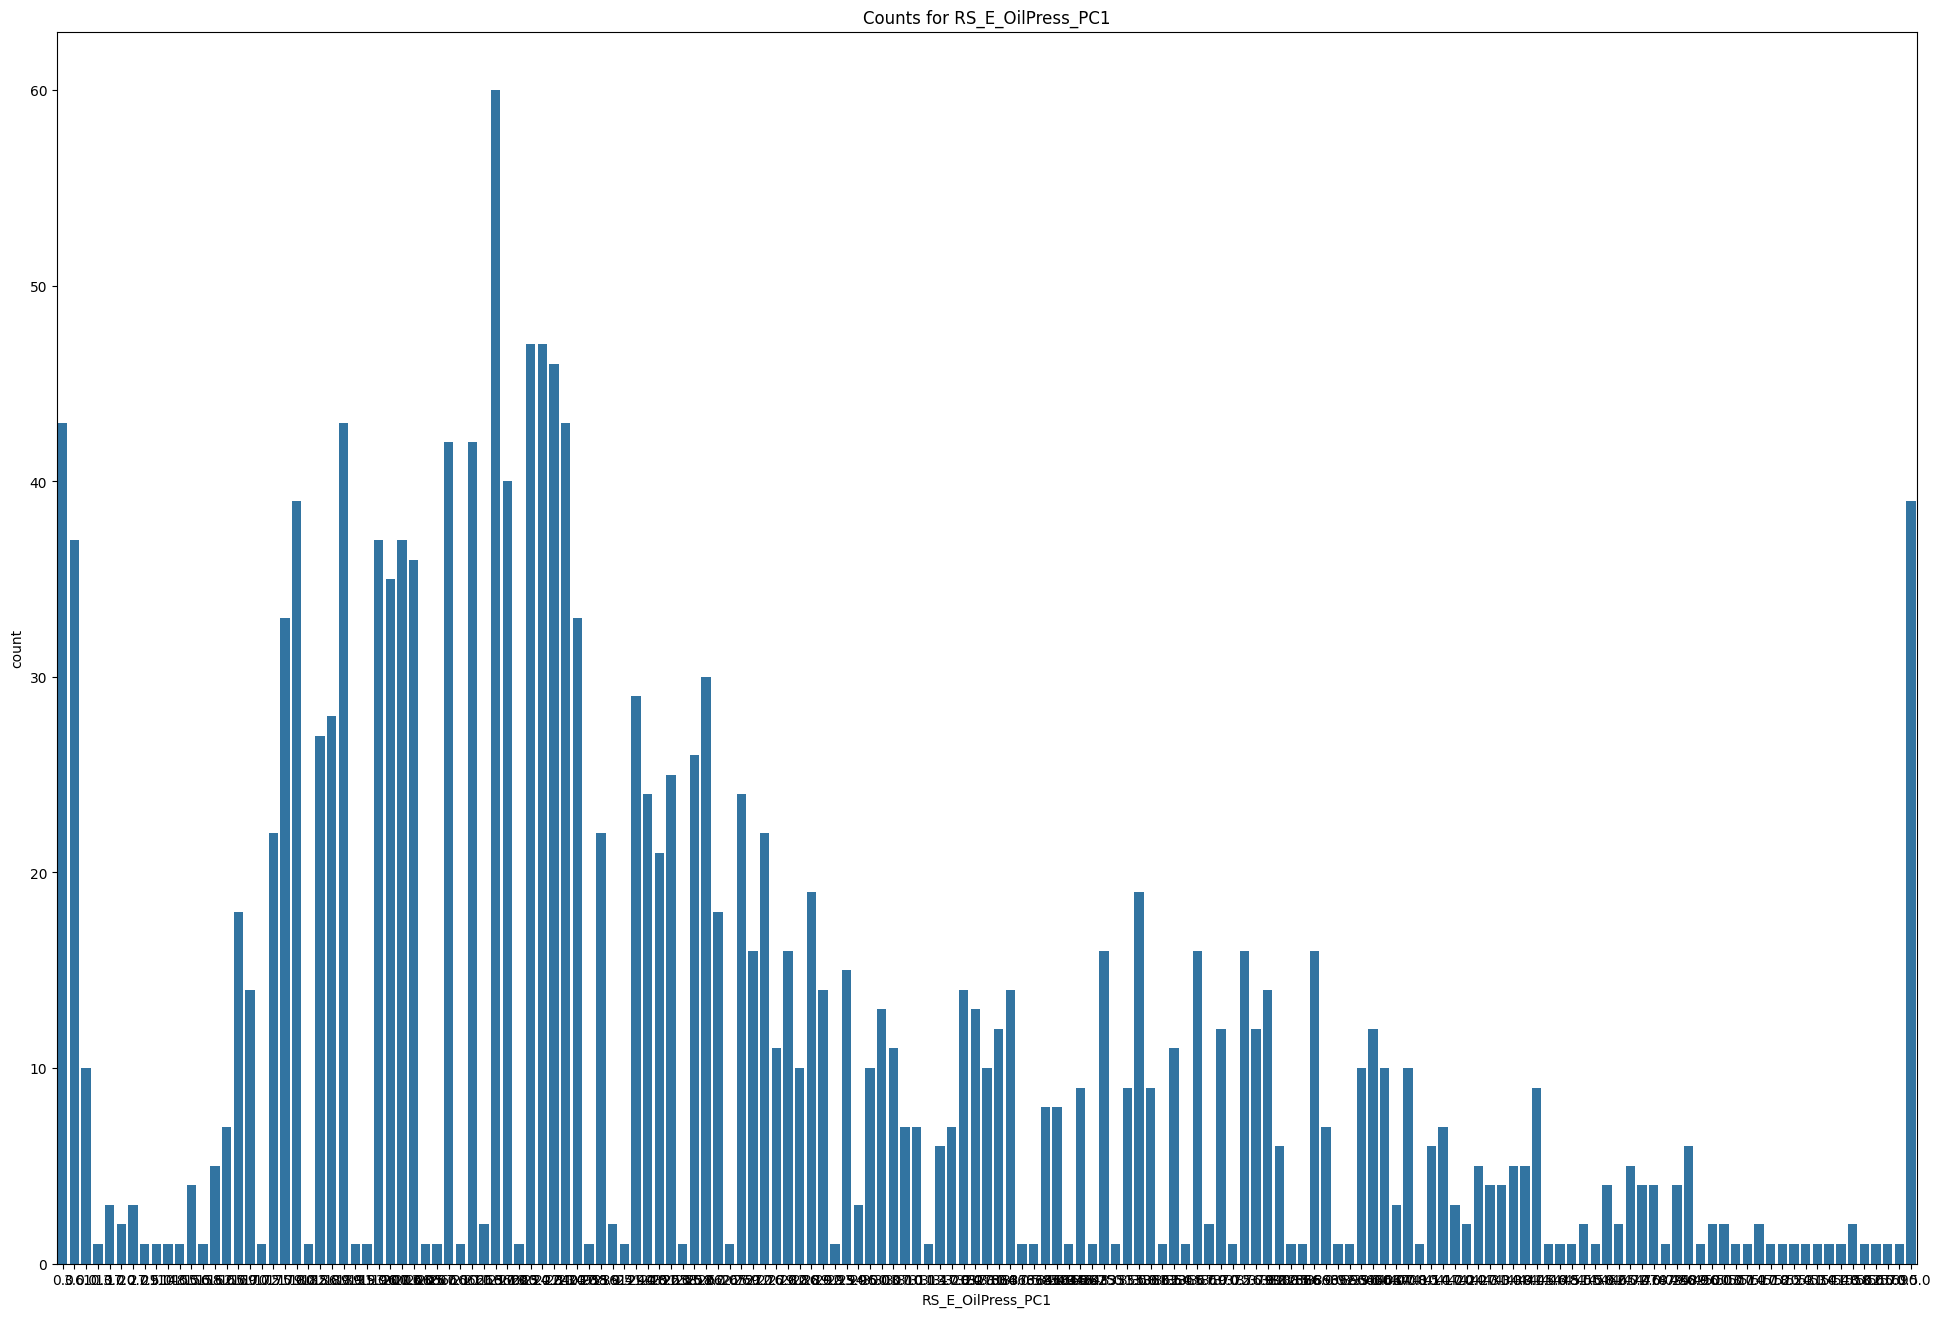

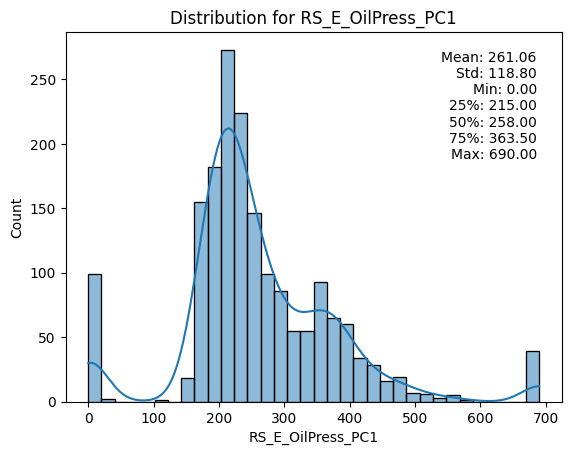

Exploring RS_E_OilPress_PC2...
count    1770.000000
mean      267.746806
std       113.776084
min         0.000000
25%       225.500000
50%       276.000000
75%       388.000000
max       690.000000
Name: RS_E_OilPress_PC2, dtype: float64


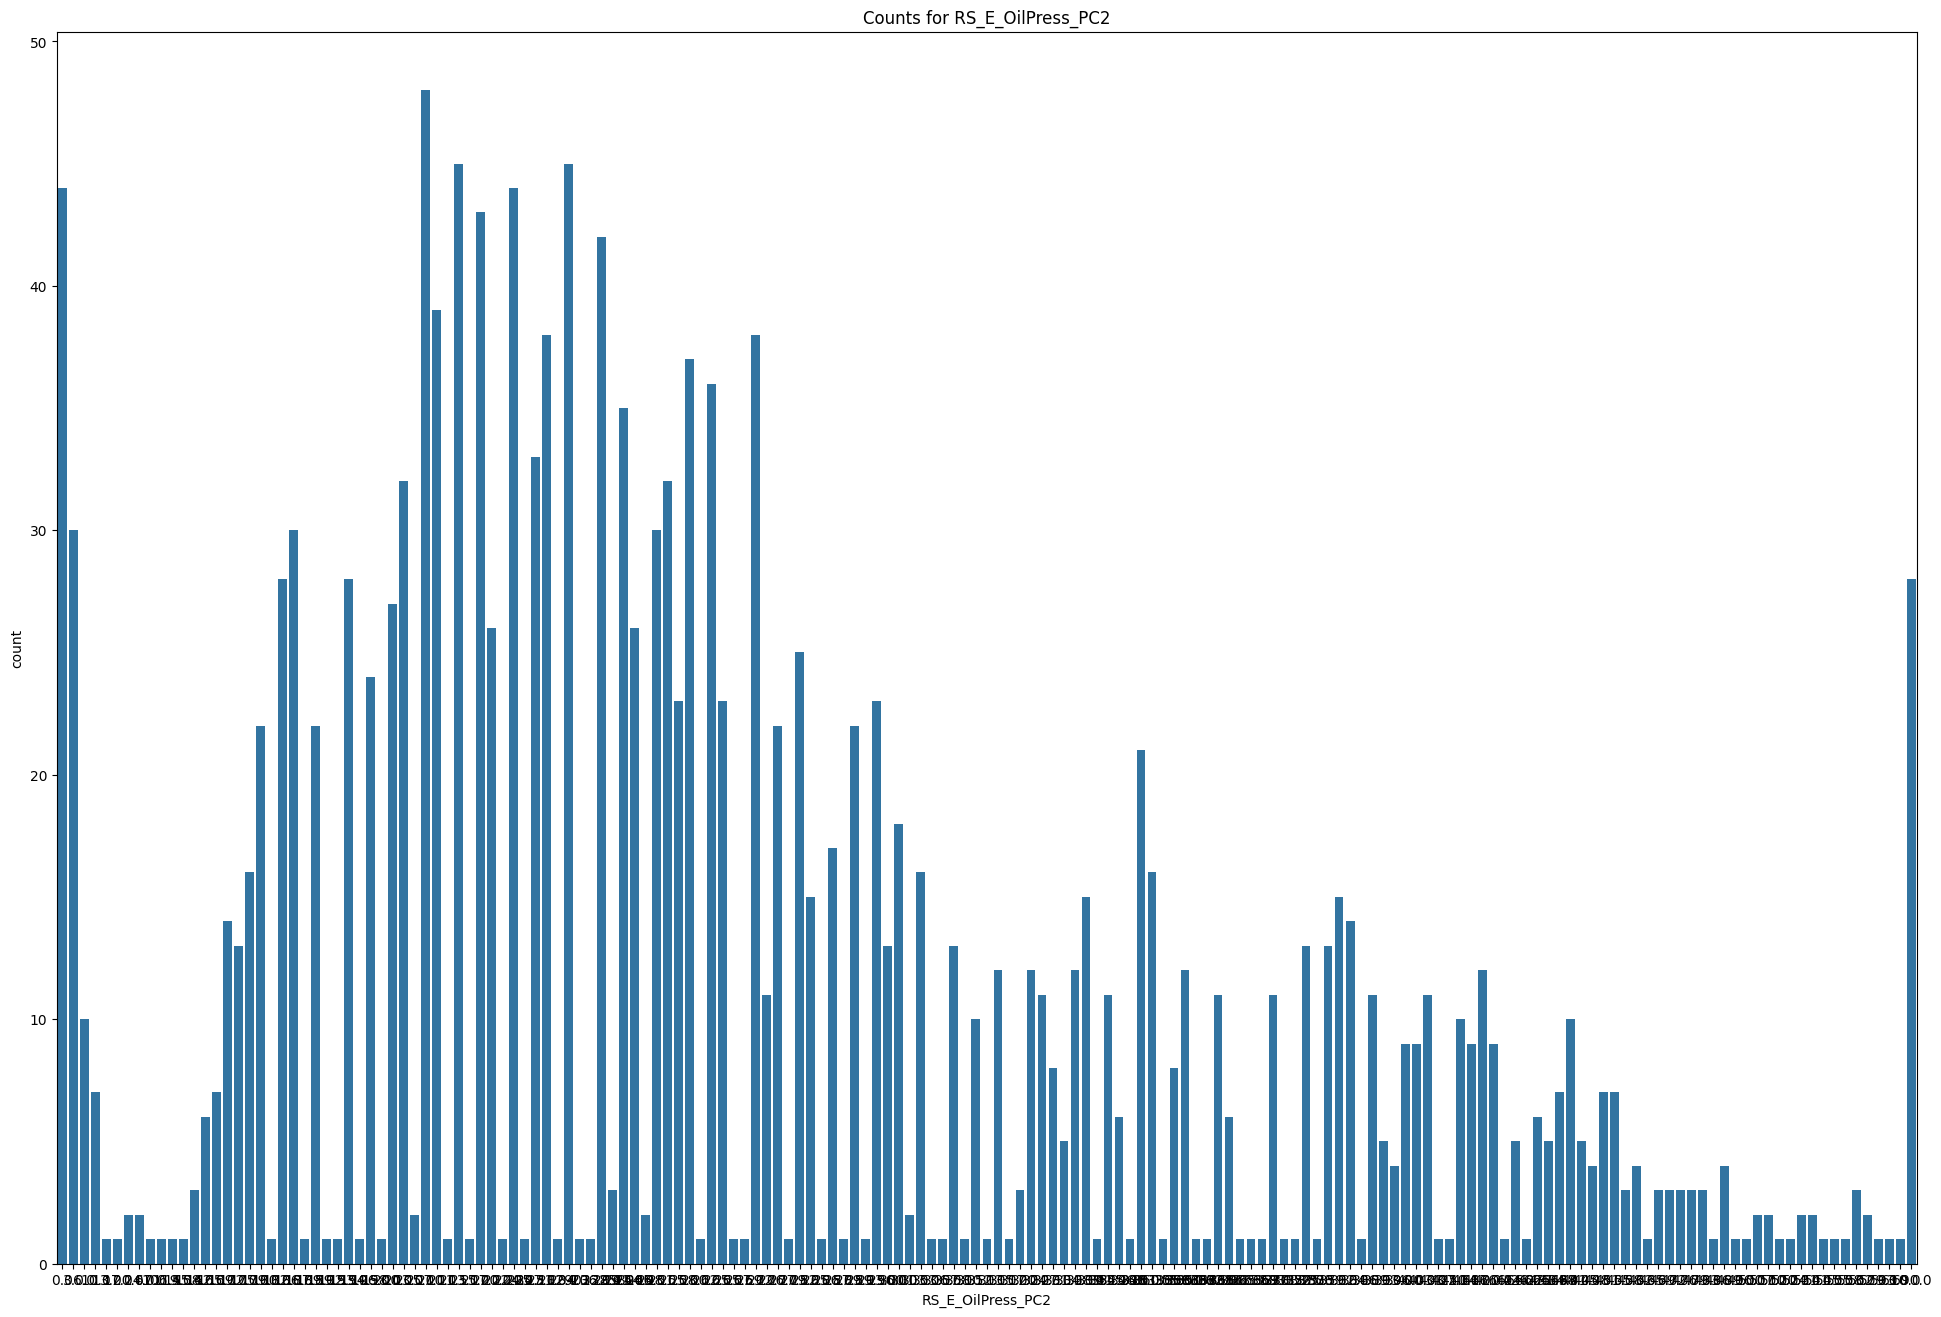

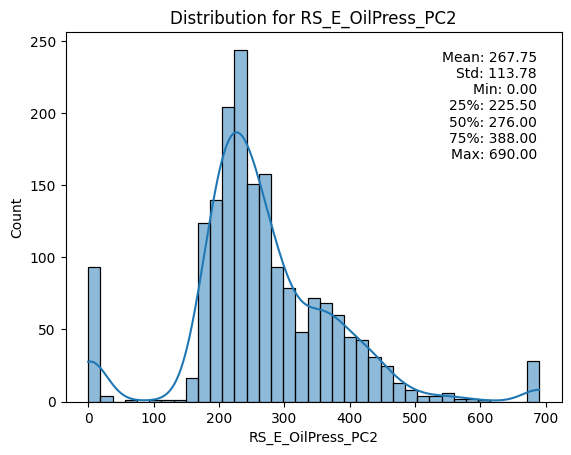

Exploring RS_E_RPM_PC1...
count    1771.000000
mean      901.771804
std       386.410892
min         0.000000
25%       799.000000
50%       802.000000
75%      1315.500000
max      2029.000000
Name: RS_E_RPM_PC1, dtype: float64


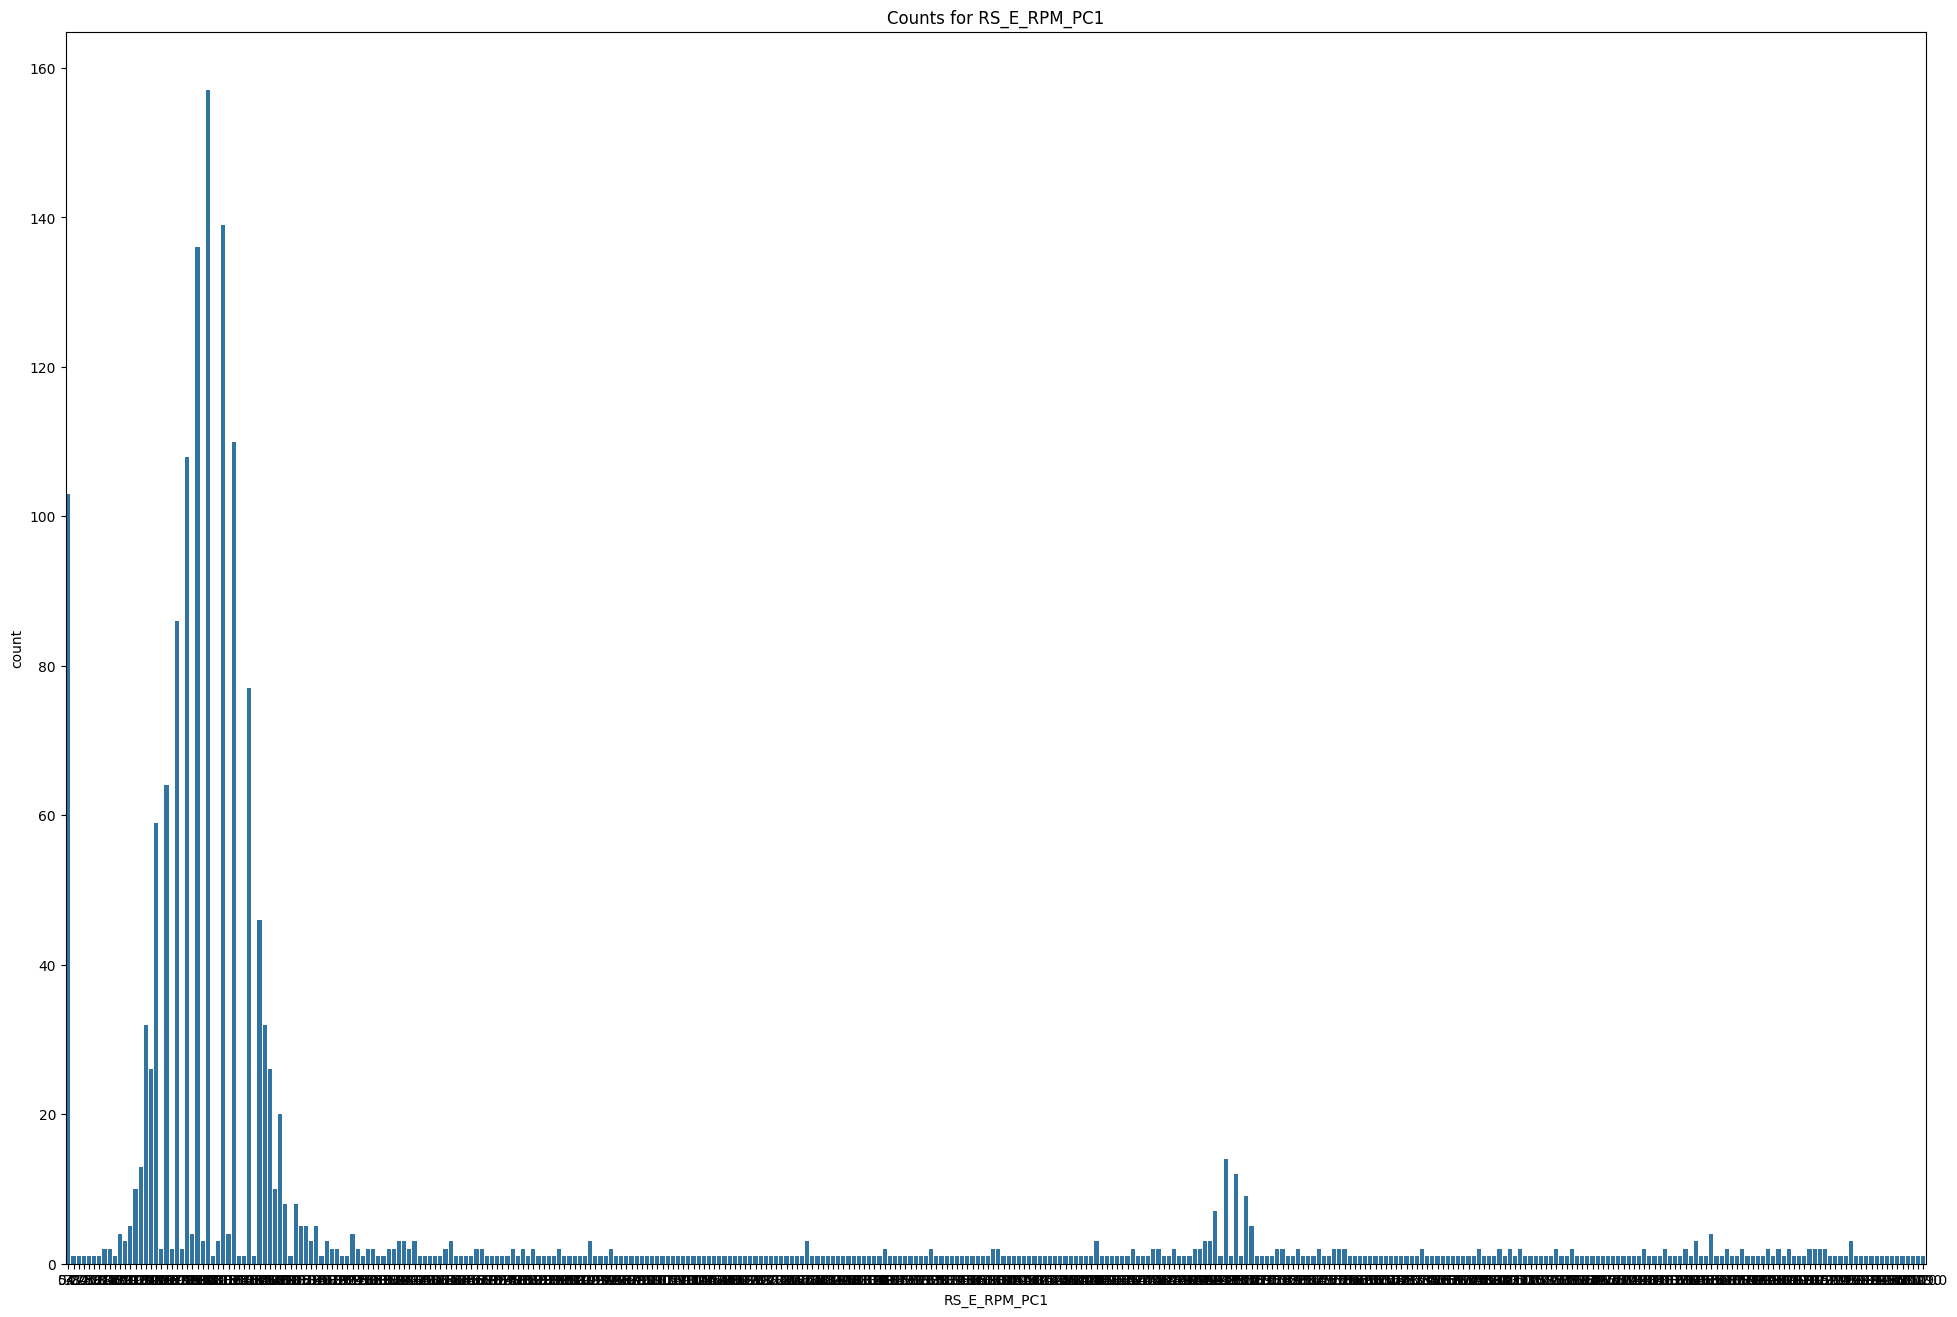

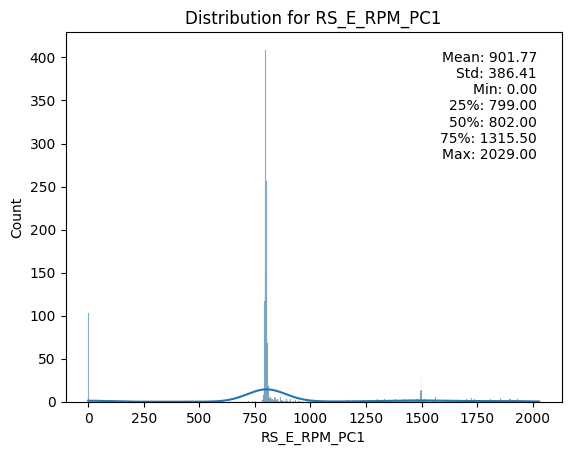

Exploring RS_E_RPM_PC2...
count    1770.000000
mean      905.980206
std       386.763854
min         0.000000
25%       799.000000
50%       803.000000
75%      1334.000000
max      2056.000000
Name: RS_E_RPM_PC2, dtype: float64


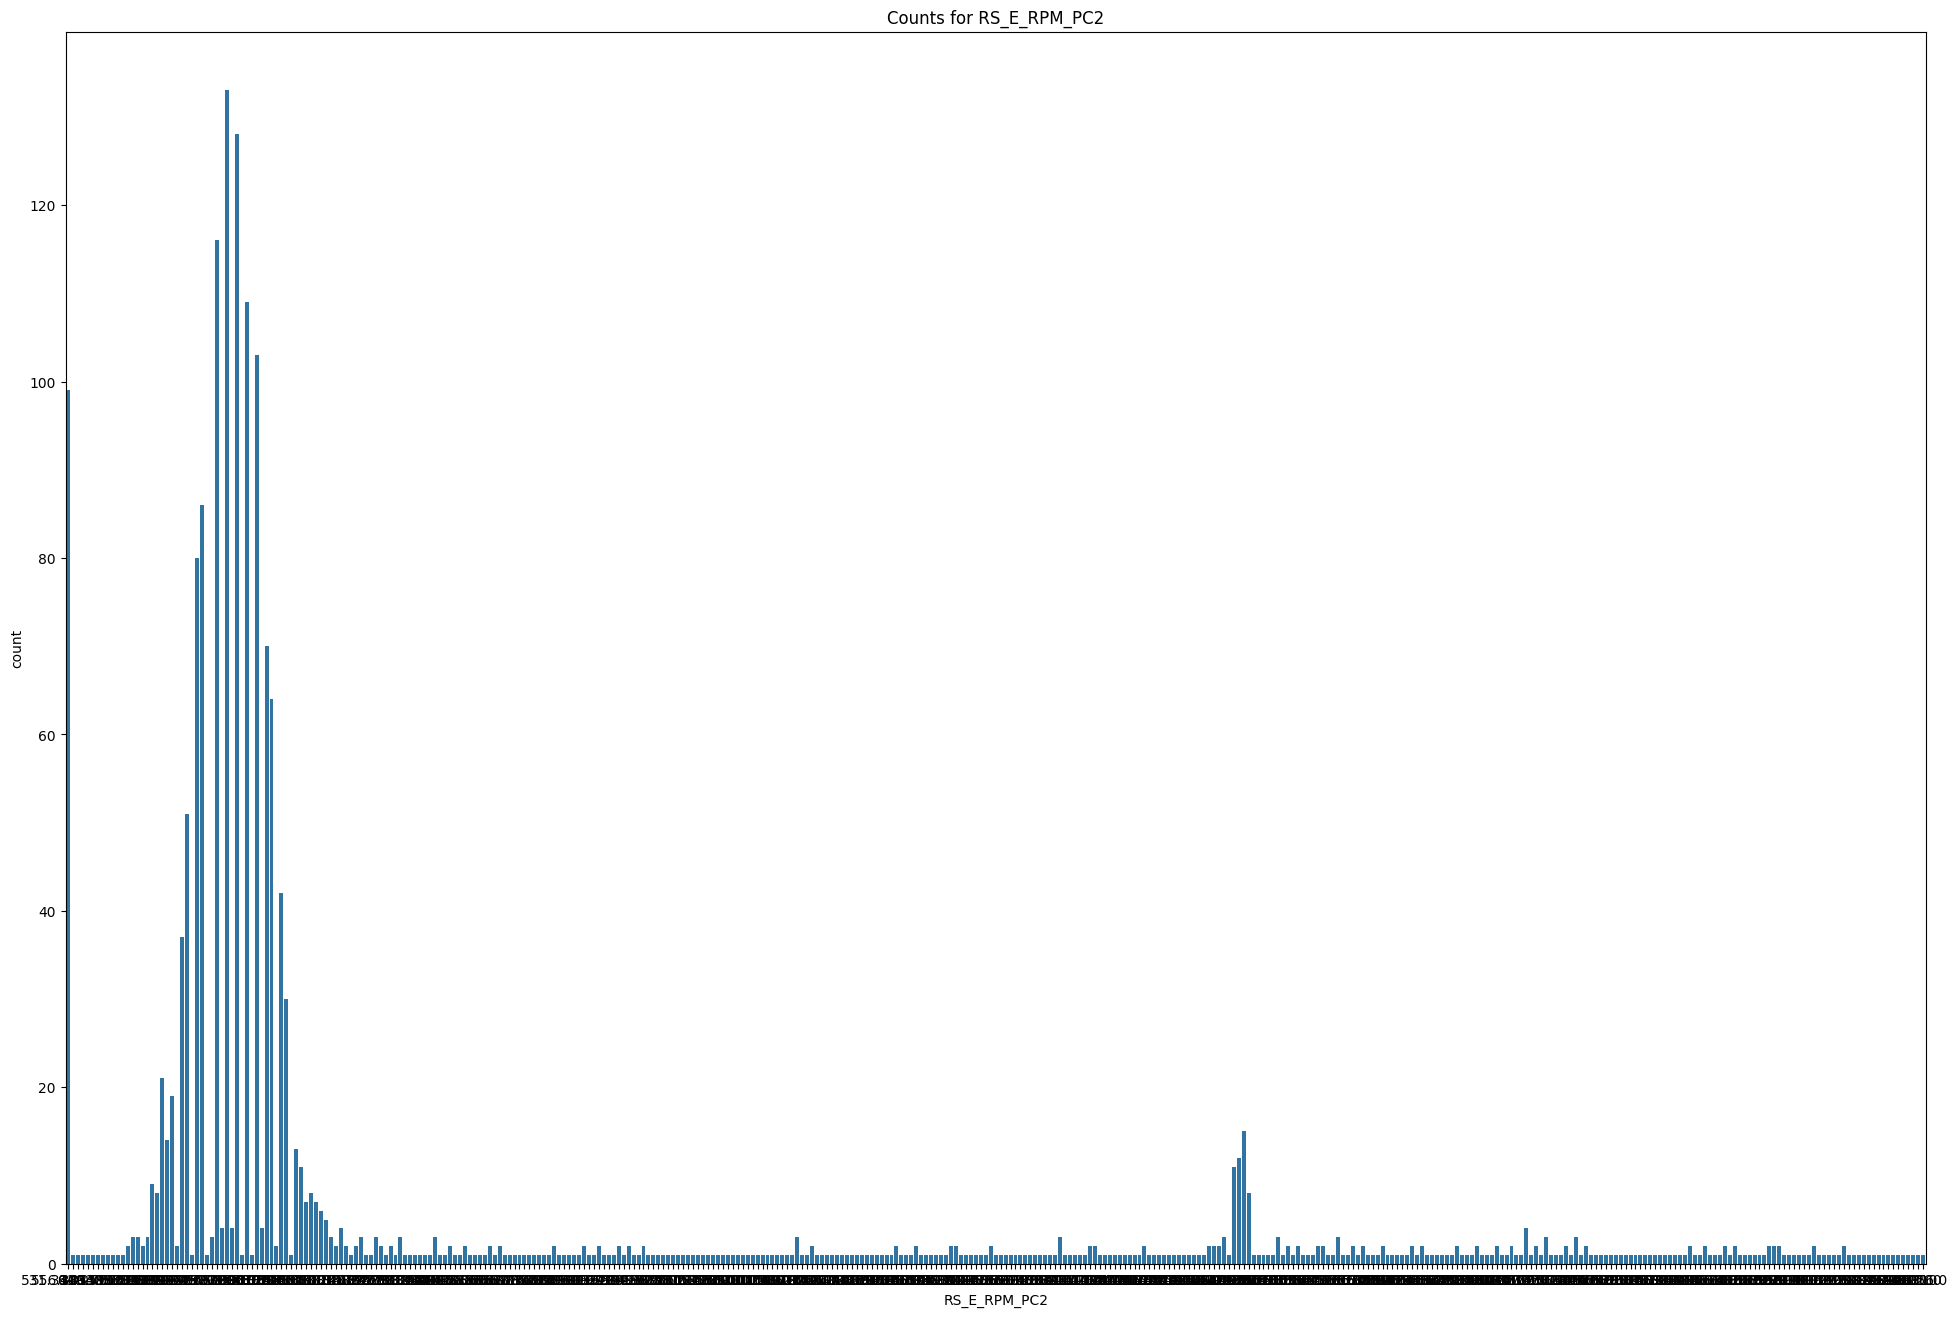

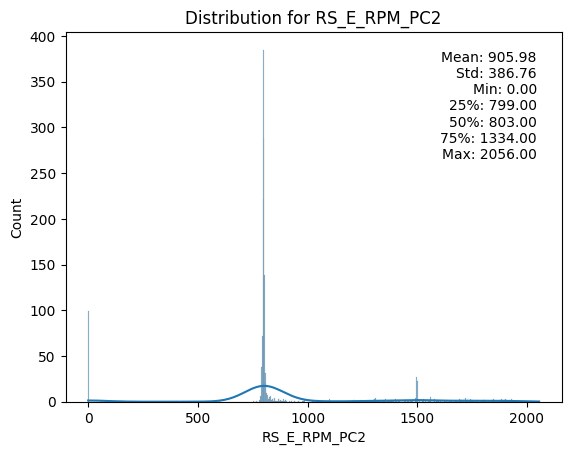

Exploring RS_E_WatTemp_PC1...
count    1771.000000
mean       76.617495
std        14.416448
min         0.000000
25%        78.000000
50%        82.000000
75%        86.000000
max        97.000000
Name: RS_E_WatTemp_PC1, dtype: float64


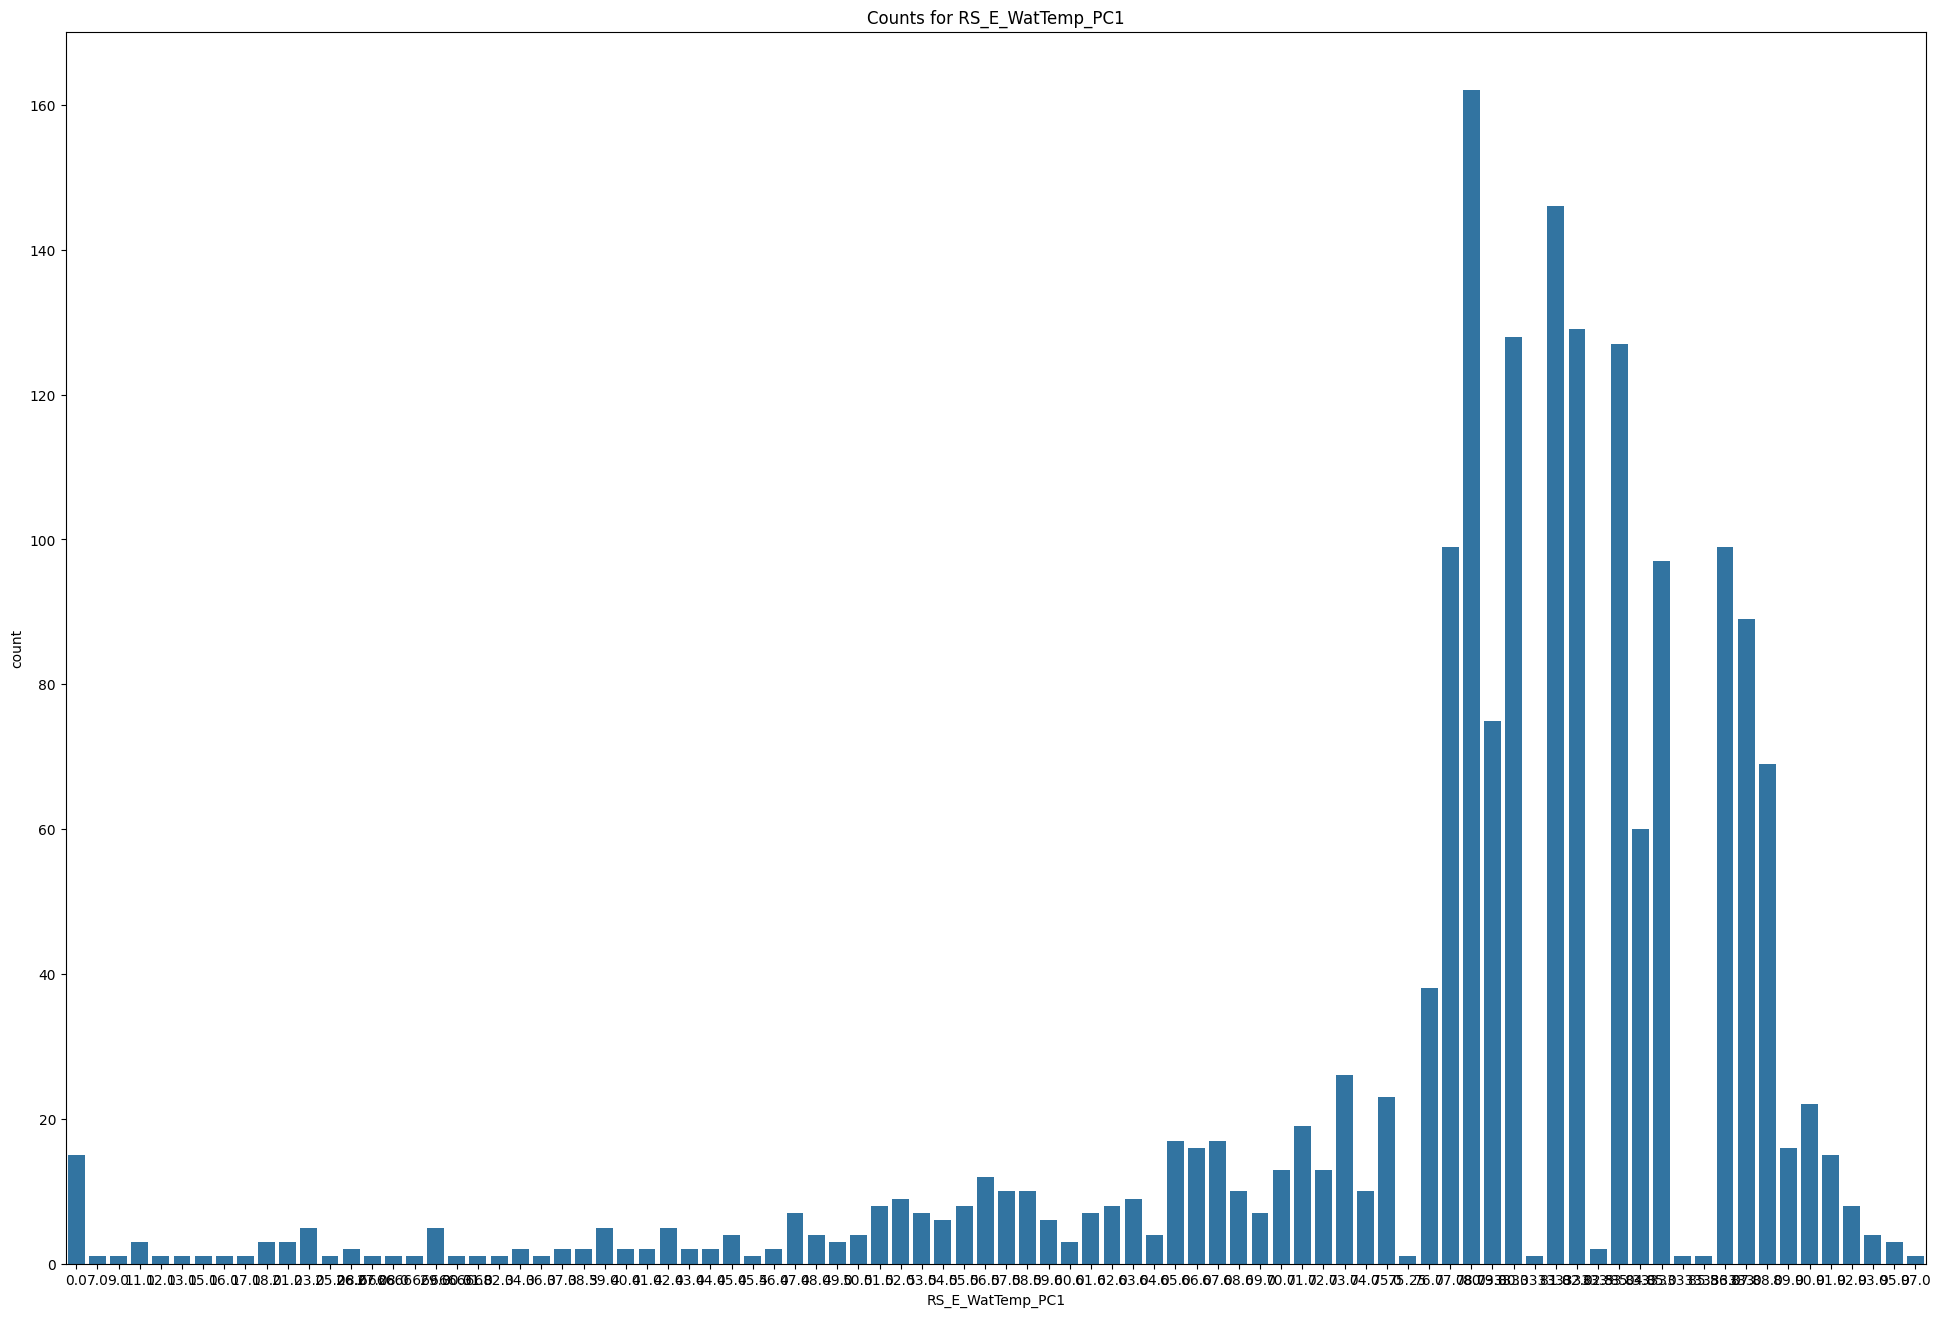

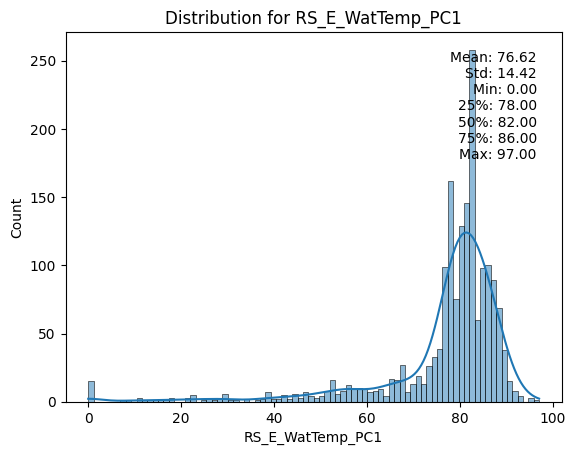

Exploring RS_E_WatTemp_PC2...
count    1770.000000
mean       76.045471
std        15.210579
min         0.000000
25%        79.000000
50%        82.000000
75%        86.000000
max        98.000000
Name: RS_E_WatTemp_PC2, dtype: float64


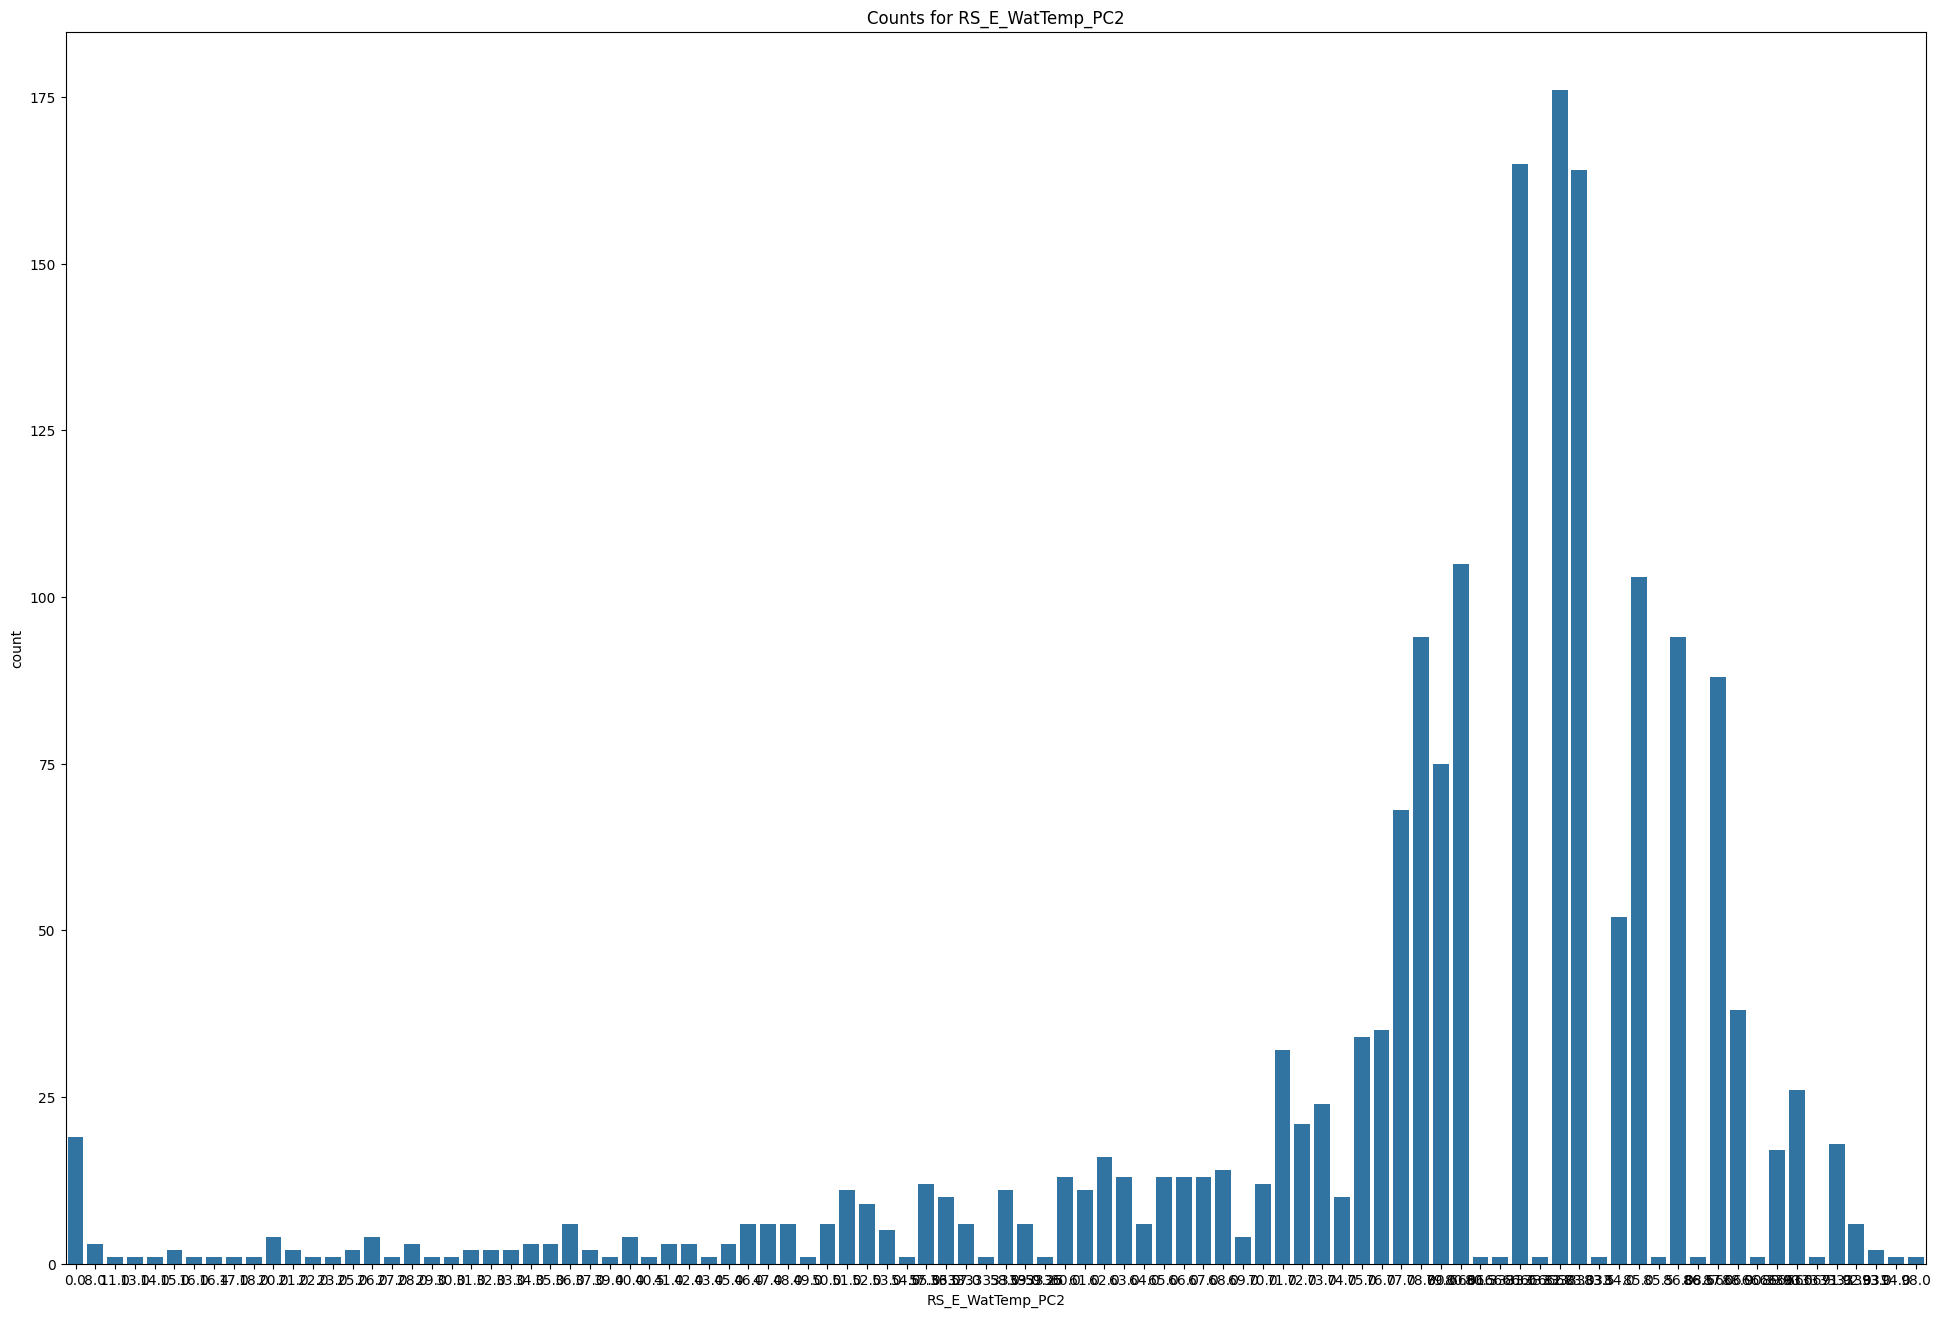

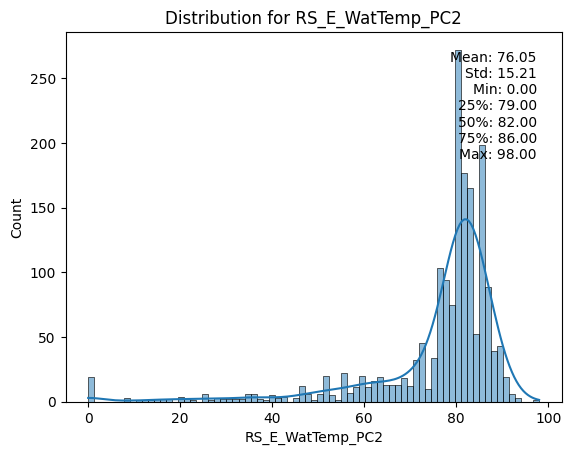

Exploring RS_T_OilTemp_PC1...
count    1771.000000
mean       76.541651
std        14.707236
min         0.000000
25%        77.000000
50%        82.000000
75%        87.250000
max       100.000000
Name: RS_T_OilTemp_PC1, dtype: float64


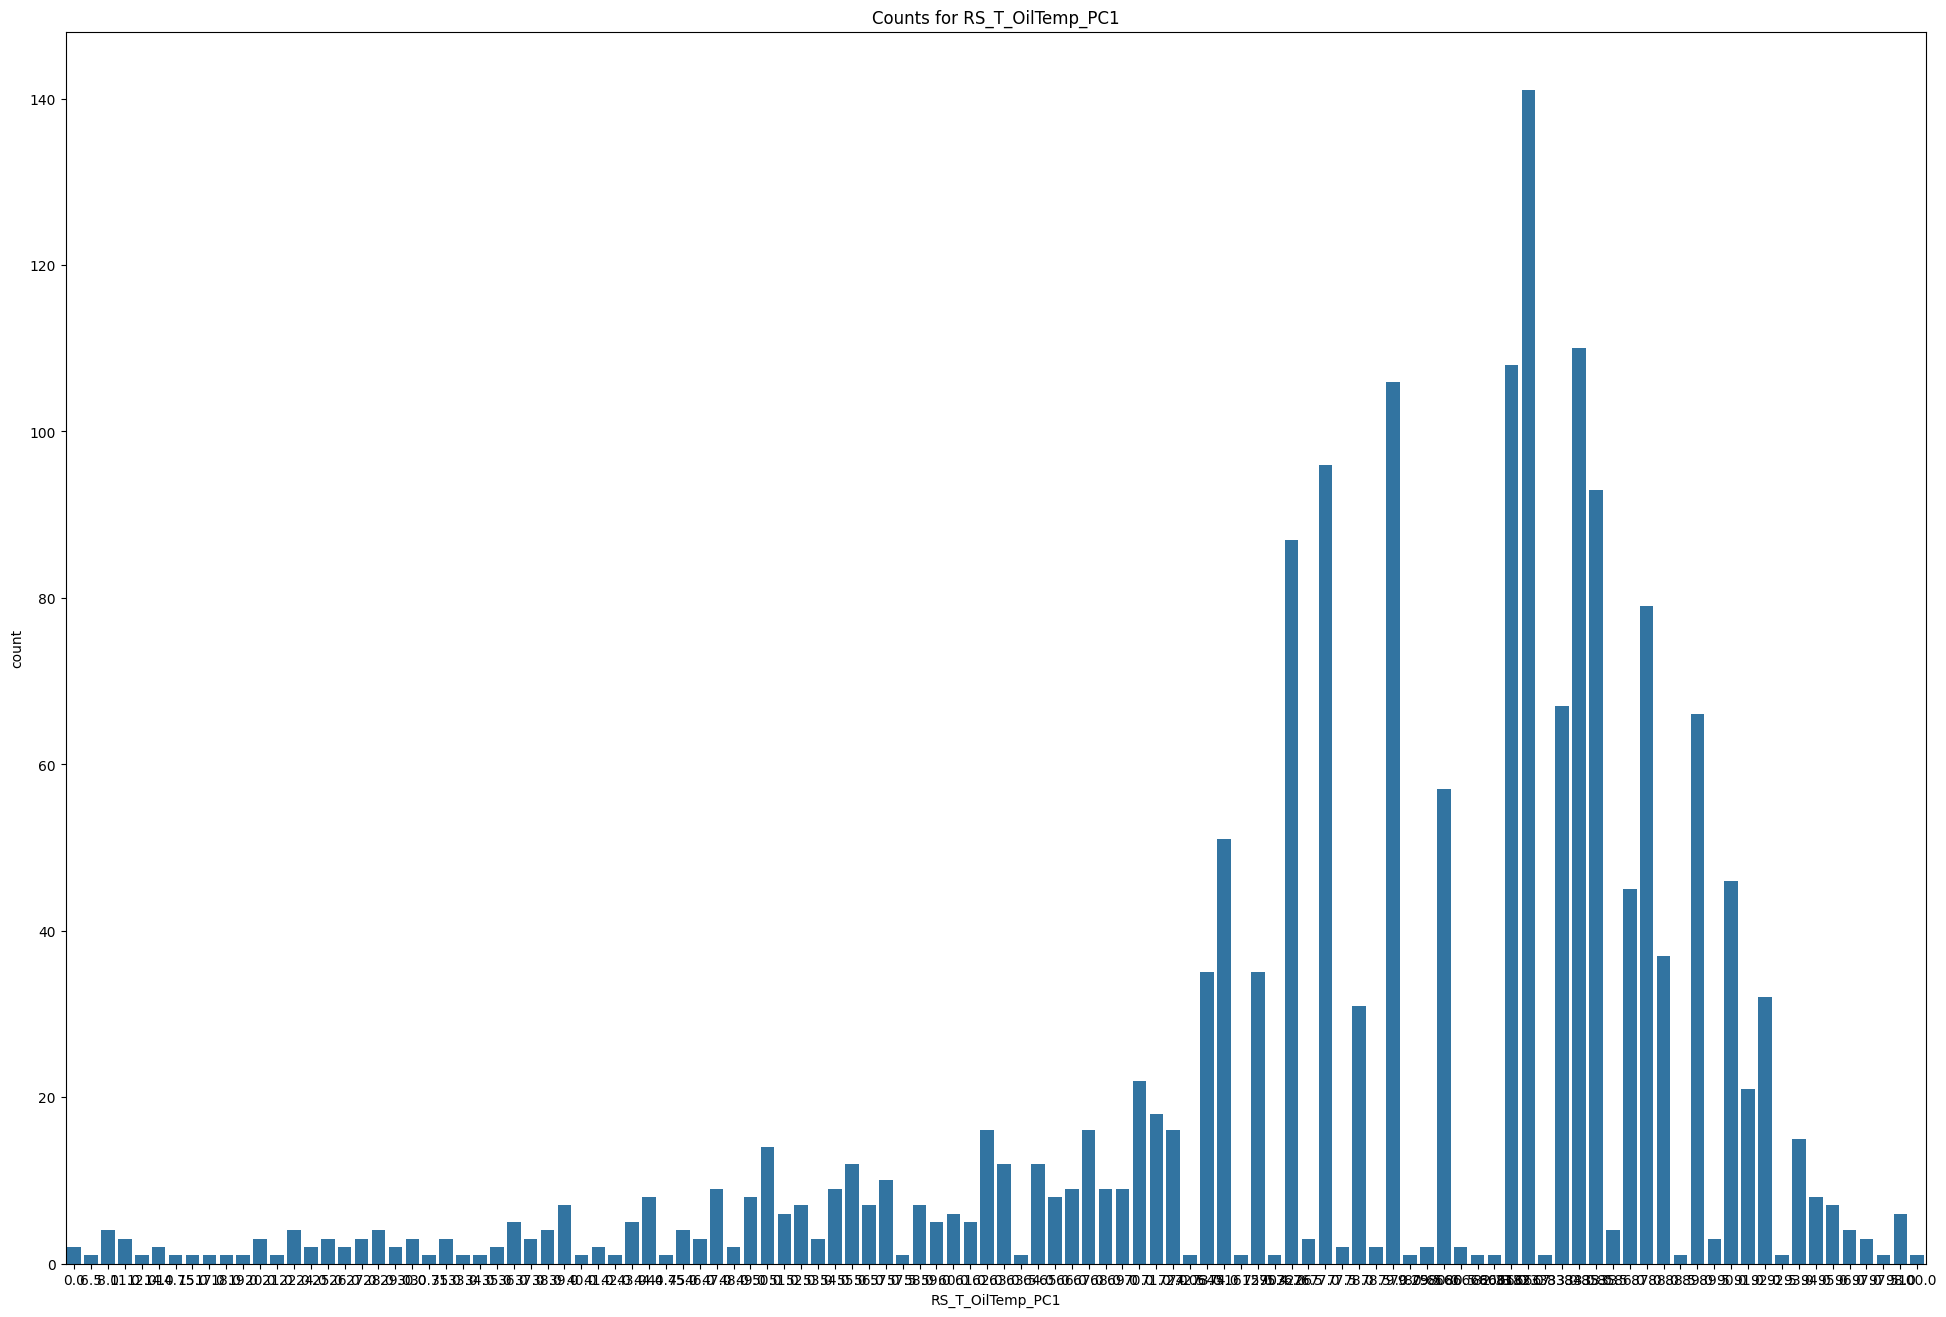

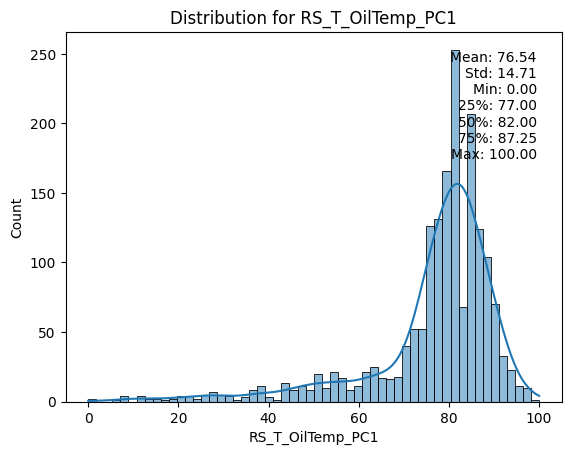

Exploring RS_T_OilTemp_PC2...
count    1770.000000
mean       76.342176
std        15.397011
min         0.000000
25%        77.000000
50%        82.000000
75%        88.000000
max       106.000000
Name: RS_T_OilTemp_PC2, dtype: float64


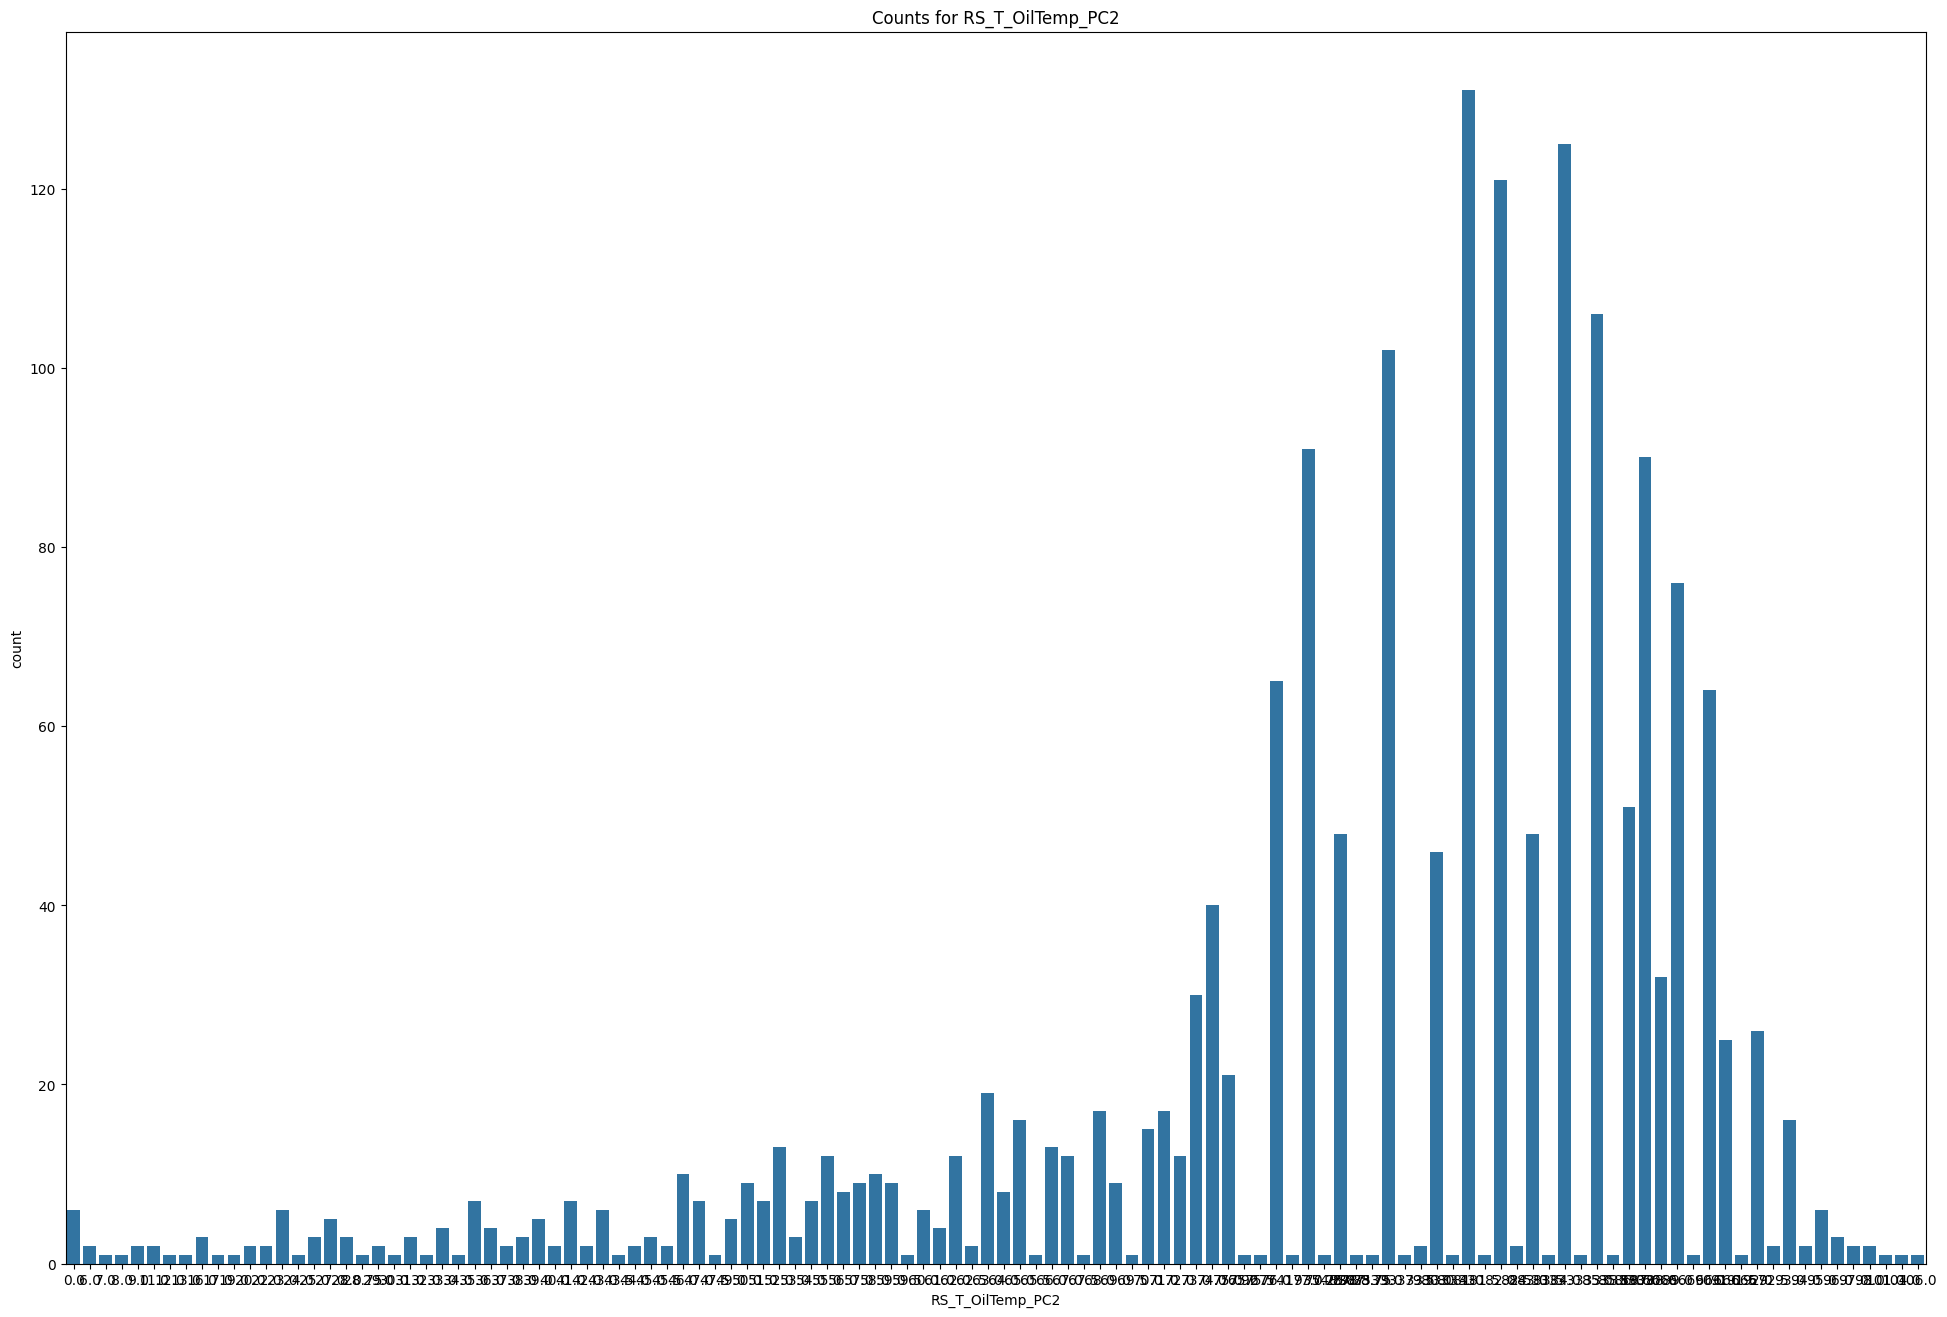

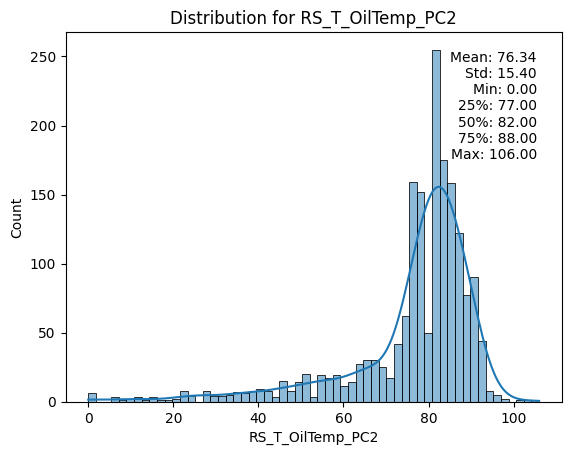

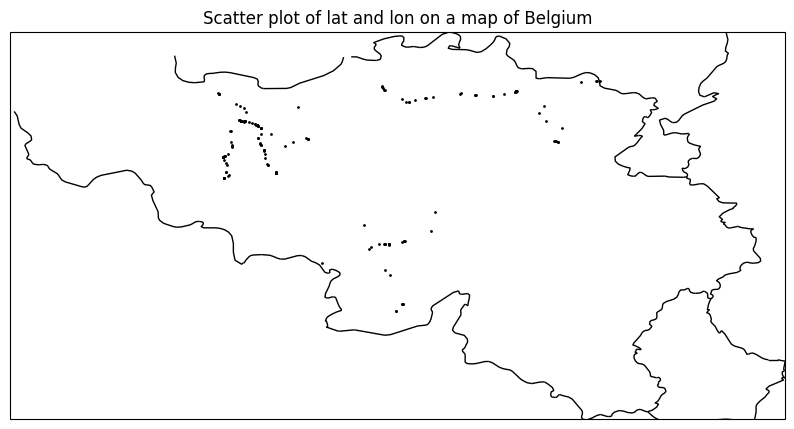

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def data_exploration_and_viz(df, temp_limit, pressure_limit):
    for col in df.columns:
        if col not in ['timestamps_UTC', 'lat', 'lon']:
            print(f"Exploring {col}...")
            col_description = df[col].describe().compute()
            print(col_description)

            # Plot distribution of each row item 
            plt.figure(figsize=(24, 16))
            col_counts = df[col].value_counts().compute()
            sns.barplot(x=col_counts.index, y=col_counts)
            plt.title(f"Counts for {col}")
            plt.show()
            sns.histplot(data=df[col].compute(), kde=True)
            plt.title(f"Distribution for {col}")
            plt.text(0.95, 0.95, f"Mean: {col_description['mean']:.2f}\nStd: {col_description['std']:.2f}\nMin: {col_description['min']:.2f}\n25%: {col_description['25%']:.2f}\n50%: {col_description['50%']:.2f}\n75%: {col_description['75%']:.2f}\nMax: {col_description['max']:.2f}", 
                     ha='right', va='top', transform=plt.gca().transAxes)
            plt.show()

    # Data Profiling:
    # Check the range and distribution of temperature and pressure readings.
    # Verify if there are any anomalies already present in the data (like temperatures above the maximum acceptable limits).
    for col in ['temperature', 'pressure']:
        print(f"Profiling {col}...")
        col_description = df[col].describe().compute()
        print(col_description)

        # Check for anomalies
        anomalies = df[df[col] > {'temperature': temp_limit, 'pressure': pressure_limit}[col]]
        print(f"Number of {col} anomalies: ", len(anomalies))

# Assuming ddf is your DataFrame, and 50 and 2000 are the maximum acceptable limits for temperature and pressure respectively
data_exploration_and_viz(ddf, 50, 2000)

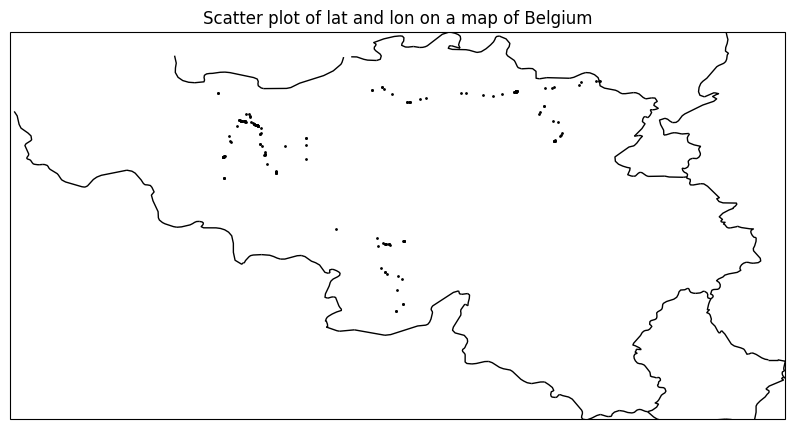

Number of clusters:  3


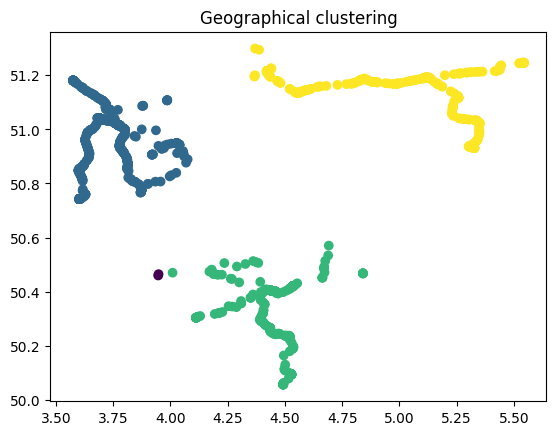

KeyError: 'temperature'

In [29]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
from scipy.stats import pearsonr

def map_visualization(df):
    # Scatter plot of 'lat' and 'lon' on a map of Belgium
    sample_df = df[['lat', 'lon']].sample(frac=0.1).compute()

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.set_extent([2.5, 6.5, 49.5, 51.5], crs=ccrs.PlateCarree())  # Set the extent to cover Belgium

    ax.add_feature(cfeature.BORDERS, edgecolor='black')
    ax.add_feature(cfeature.LAND, facecolor='white')

    ax.scatter(sample_df['lon'], sample_df['lat'], s=1, color='black', transform=ccrs.PlateCarree())

    plt.title('Scatter plot of lat and lon on a map of Belgium')
    plt.show()

def geospatial_analysis(df):
    # Convert DataFrame to GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

    # Geographical clustering
    # Standardize the coordinates
    coords = StandardScaler().fit_transform(df[['lat', 'lon']])
    db = DBSCAN(eps=0.3, min_samples=10).fit(coords)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print("Number of clusters: ", n_clusters)

    # Plot the clusters
    plt.scatter(df['lon'], df['lat'], c=labels)
    plt.title('Geographical clustering')
    plt.show()

    # Geographically Weighted Regression (GWR)
    # TODO: Add code for GWR

map_visualization(ddf)
geospatial_analysis(ddf)

c:\Python311\Lib\site-packages\dask\dataframe\core.py:4529: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('timestamps_UTC', 'float64'))

  warnings.warn(meta_warning(meta))


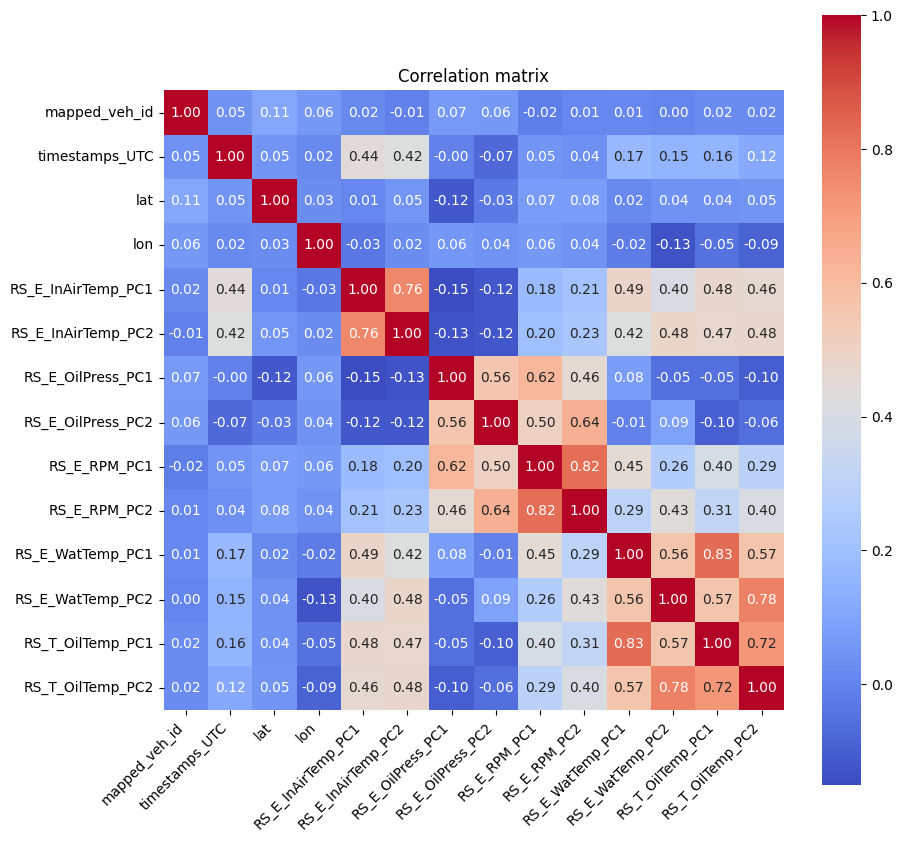

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

def correlation_analysis(df):
    # cast timestamp to float64
    dfs = df
    dfs['timestamps_UTC'] = dfs['timestamps_UTC'].apply(lambda x: x.timestamp())

    # Calculate the correlation matrix
    corr_matrix = dfs.corr()

    # Plot the correlation matrix as a heatmap
    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
    # Set the xticklabels and yticklabels to the column names of the DataFrame
    ax.set_xticklabels(corr_matrix.columns,rotation=45, horizontalalignment='right')
    ax.set_yticklabels(corr_matrix.columns,rotation=0)

    plt.title('Correlation matrix')
    plt.show()

correlation_analysis(ddf)

In [52]:
def data_quality_checks(df):
    # Check for missing values
    print("dataframe null values count")
    print(df.isnull().sum().compute())

    # Check for nan values
    print("dataframe nan values count")
    print(df.isna().sum().compute())

    # Check for duplicates
    print("dataframe duplicates count")
    print(df.compute().duplicated().sum())


    # let's Look for any signs of sensor malfunctions or inconsistencies.
    # Check for basic ouliers (if it's more than 3 standard deviations away from the mean.) 
    # in every features and "plot them"
    """for col in df.columns:
        if col not in ['timestamps_UTC', 'lat', 'lon', 'mapped_veh_id']:
                    n_outliers = ((df[col] - df[col].mean()).abs() > 3*df[col].std()).sum()

            print(f"Exploring {col}...")
    TODO: add code for outliers detection
    """
data_quality_checks(ddf)

dataframe null values count
mapped_veh_id         0
timestamps_UTC        0
lat                   0
lon                   0
RS_E_InAirTemp_PC1    0
RS_E_InAirTemp_PC2    1
RS_E_OilPress_PC1     0
RS_E_OilPress_PC2     1
RS_E_RPM_PC1          0
RS_E_RPM_PC2          1
RS_E_WatTemp_PC1      0
RS_E_WatTemp_PC2      1
RS_T_OilTemp_PC1      0
RS_T_OilTemp_PC2      1
dtype: int64
dataframe nan values count
mapped_veh_id         0
timestamps_UTC        0
lat                   0
lon                   0
RS_E_InAirTemp_PC1    0
RS_E_InAirTemp_PC2    1
RS_E_OilPress_PC1     0
RS_E_OilPress_PC2     1
RS_E_RPM_PC1          0
RS_E_RPM_PC2          1
RS_E_WatTemp_PC1      0
RS_E_WatTemp_PC2      1
RS_T_OilTemp_PC1      0
RS_T_OilTemp_PC2      1
dtype: int64
dataframe duplicates count
0


Number of temperature anomalies: 0
Number of temperature anomalies: 0
Number of engine anomalies: 9


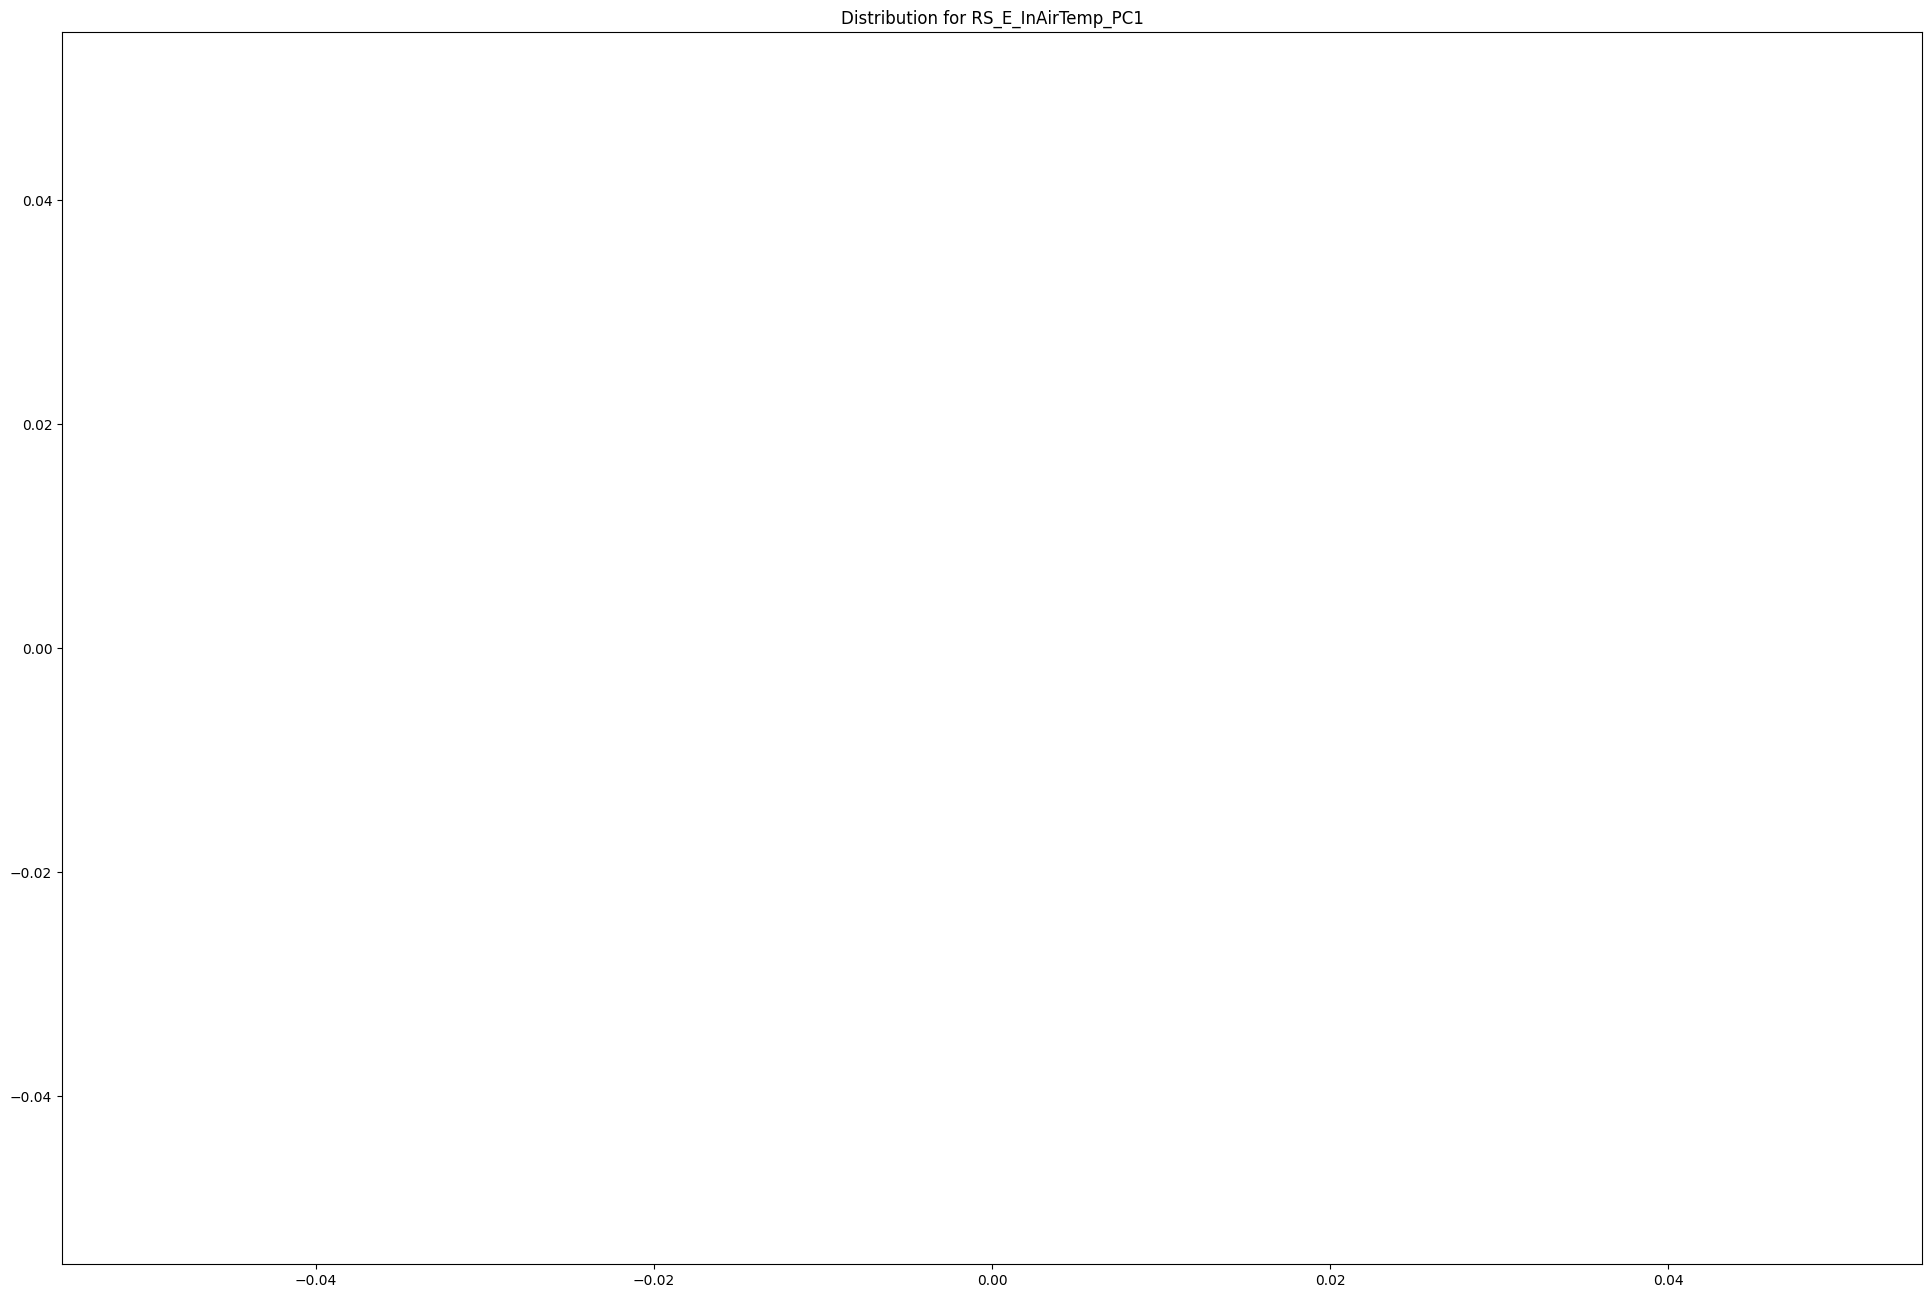

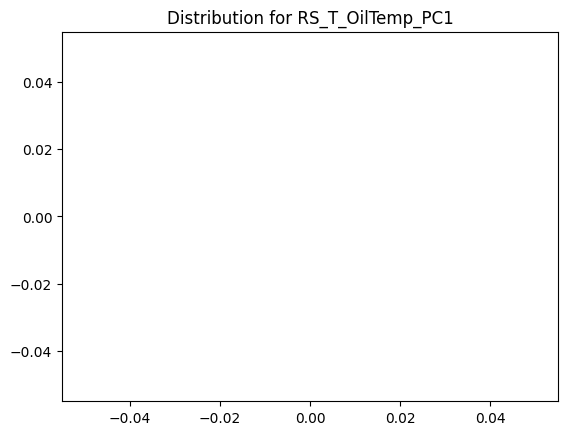

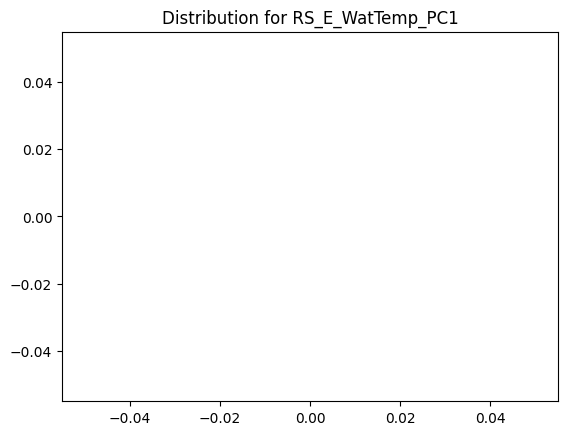

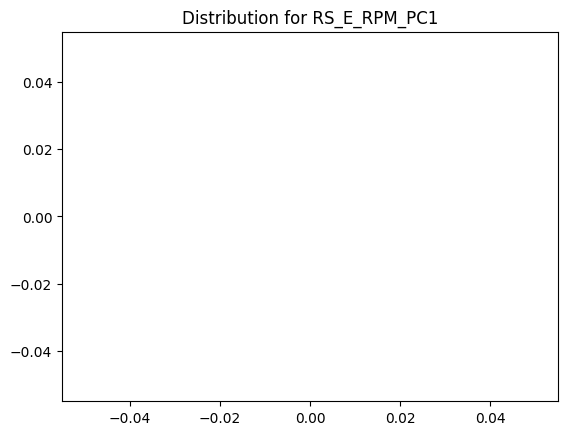

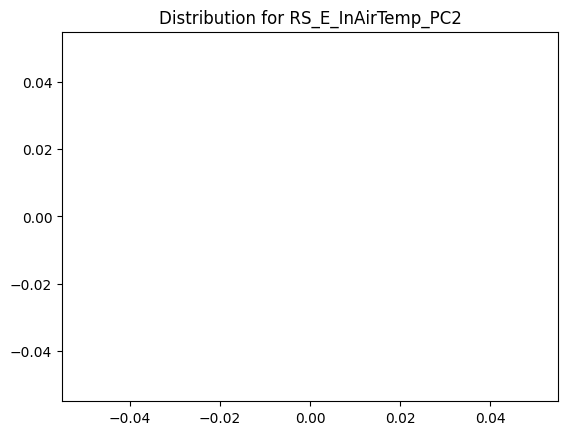

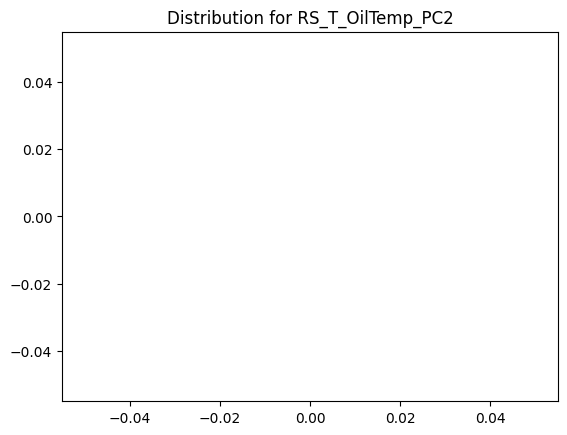

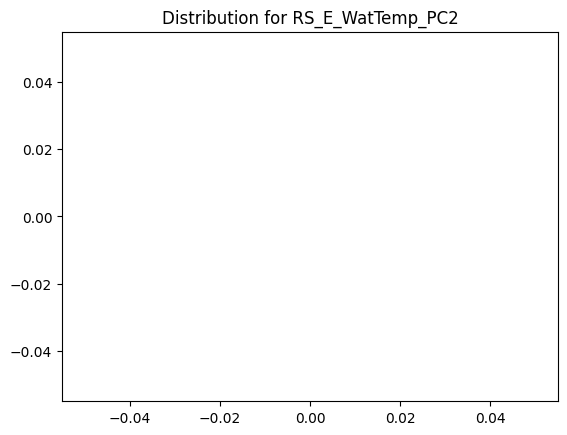

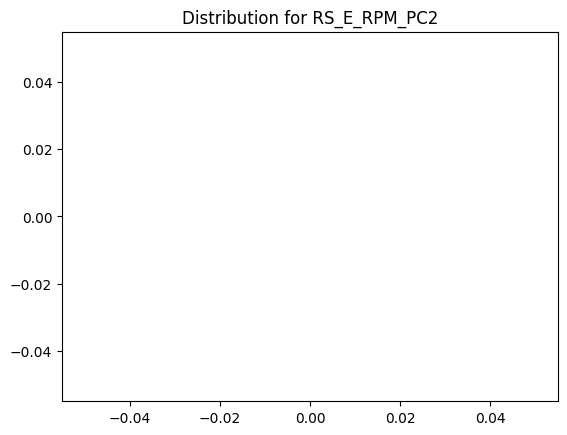

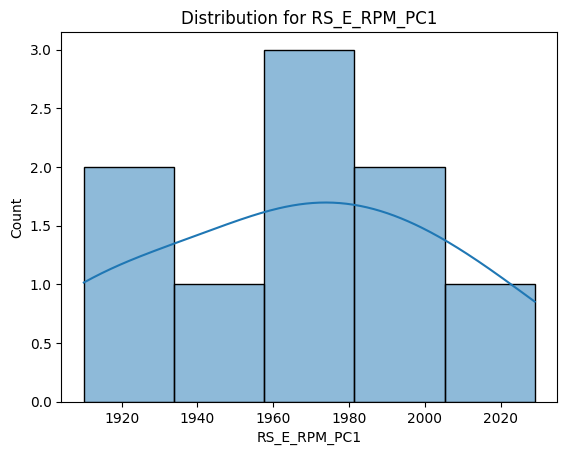

In [50]:
def identify_easy_anomalies(df, max_Airtemp=65+273.15, max_Oiltemp=115+273.15,max_wattemp=100+273.15,
                        max_RPM=1950, ):
    # Identify sensors anomalies
    sensor1_anomalies = df[((df['RS_E_InAirTemp_PC1'] > max_Airtemp) | (df['RS_T_OilTemp_PC1'] > max_Oiltemp) | (df['RS_E_WatTemp_PC1'] > max_wattemp) & (df['RS_E_RPM_PC1']  >10))]
    print(f"Number of sensor1 ourliers: {len(sensor1_anomalies)}")

    sensor2_anomalies = df[((df['RS_E_InAirTemp_PC2'] > max_Airtemp) | (df['RS_T_OilTemp_PC2'] > max_Oiltemp) | (df['RS_E_WatTemp_PC2'] > max_wattemp) & (df['RS_E_RPM_PC2']  > 10))]
    print(f"Number of sensor2 anomalies: {len(sensor2_anomalies)}")

    # identify engine anomalies
    engine_anomalies = df[(df['RS_E_RPM_PC1'] > max_RPM) | (df['RS_E_RPM_PC2'] > max_RPM)]
    print(f"Number of engine anomalies: {len(engine_anomalies)}")


    #plot anomalies
    plt.figure(figsize=(24, 16))
    sns.histplot(data=sensor1_anomalies['RS_E_InAirTemp_PC1'].compute(), kde=True)
    plt.title(f"Distribution for RS_E_InAirTemp_PC1")
    plt.show()
    sns.histplot(data=sensor1_anomalies['RS_T_OilTemp_PC1'].compute(), kde=True)
    plt.title(f"Distribution for RS_T_OilTemp_PC1")
    plt.show()
    sns.histplot(data=sensor1_anomalies['RS_E_WatTemp_PC1'].compute(), kde=True)
    plt.title(f"Distribution for RS_E_WatTemp_PC1")
    plt.show()
    sns.histplot(data=sensor1_anomalies['RS_E_RPM_PC1'].compute(), kde=True)
    plt.title(f"Distribution for RS_E_RPM_PC1")
    plt.show()
    sns.histplot(data=sensor2_anomalies['RS_E_InAirTemp_PC2'].compute(), kde=True)
    plt.title(f"Distribution for RS_E_InAirTemp_PC2")
    plt.show()
    sns.histplot(data=sensor2_anomalies['RS_T_OilTemp_PC2'].compute(), kde=True)
    plt.title(f"Distribution for RS_T_OilTemp_PC2")
    plt.show()
    sns.histplot(data=sensor2_anomalies['RS_E_WatTemp_PC2'].compute(), kde=True)
    plt.title(f"Distribution for RS_E_WatTemp_PC2")
    plt.show()
    sns.histplot(data=sensor2_anomalies['RS_E_RPM_PC2'].compute(), kde=True)
    plt.title(f"Distribution for RS_E_RPM_PC2")
    plt.show()
    sns.histplot(data=engine_anomalies['RS_E_RPM_PC1'].compute(), kde=True)
    plt.title(f"Distribution for RS_E_RPM_PC1")
    plt.show()
    # Return anomalies
    return sensor1_anomalies, sensor2_anomalies

sensor1_anomalies, sensor2_anomalies = identify_easy_anomalies(ddf)

# Phase 3: Data Preparation
This phase covers constructing the final data set for modeling tools. Steps include selecting data, cleansing data, constructing data, integrating data, and formatting data.

Select Data:

Decide on data based on relevance, quality, and technical constraints.
Explain data inclusions/exclusions and prioritize attributes.
Clean Data:

Ensure data cleanliness, address missing values using appropriate techniques.
Document how quality problems were addressed.
Construct Data:

Develop new records or derived attributes, considering modeling needs.
Example: Create "income per head" as a derived attribute.
Integrate Data:

Combine information from multiple tables or records.
Perform aggregations to summarize information.
Format Data:

Change data format or design to suit modeling tools.
Example: Trim strings, reorganize information.